In [2]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../data/2_extracted_works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)


In [4]:
works_bjp = pl.read_csv("../data/2_extracted_works/works_bjp.csv")
works_bjp = works_bjp.filter(pl.col("year") != 2025)

In [5]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) 

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns( #remove abstract, add words : survey, overview, state of?
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

works

shape: (689_361, 1_080)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ ros stress  ┆ 2004 ┆ 1881        ┆ 1          ┆ … ┆ 35.103559 ┆ 3          ┆ false  ┆ false      │
│ in cancer   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ cells and…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ aminoglycos ┆ 2010 ┆ 1294        ┆ 1          ┆ … ┆ 24.857588 ┆ 2          ┆ false  ┆ false      │
│ ide         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ modifying   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ enzym…      ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ overcoming  ┆ 2015 ┆ 898         ┆ 2          ┆ … ┆ 23.127161 ┆ 6          ┆ false  ┆ false      │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ blood–brain ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ tum…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ targeting   ┆ 2008 ┆ 786         ┆ 1          ┆ … ┆ 14.902469 ┆ 4          ┆ false  ┆ false      │
│ the pi3k/ak ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t/mtor pa…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ if not      ┆ 2001 ┆ 722         ┆ 1          ┆ … ┆ 12.263251 ┆ 3          ┆ false  ┆ false      │
│ apoptosis,  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ then what?  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t…          ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│ contributor ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ s           ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ copyright   ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ preface     ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ dendritic   ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ cells in    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ inducti…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ protein con ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 6          ┆ false  ┆ false      │
│ formation   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ affects t…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [6]:
year_begin = 1920
year_end = 2024
works_bjp = works_bjp.with_columns(
    age=2025 - pl.col("year")
)

cbc_per_year = (
    works
    .group_by("year")
    .agg(
        pl.col("cited_by_count").mean().alias("mean_cited_by_count")
    )
)


works_bjp = works_bjp.join(
    cbc_per_year,
    on="year",
    how="left"
)


works_bjp = (
    works_bjp
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)

bjp_cols_authors = [col for col in works_bjp.columns if col.startswith("author_")]

works_bjp = works_bjp.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in bjp_cols_authors]
    )

)

works_bjp = works_bjp.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works_bjp = works_bjp.with_columns( #remove abstract, add words : survey, overview, state of?
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works_bjp = works_bjp.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works_bjp = works_bjp.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


bjp_group_references_mean = (
    works_bjp.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works_bjp

shape: (26_115, 394)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ animal      ┆ 2010 ┆ 3465        ┆ 1          ┆ … ┆ 66.562243 ┆ 5          ┆ false  ┆ false      │
│ research:   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ reporting   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ <i>…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ principles  ┆ 2010 ┆ 2474        ┆ 1          ┆ … ┆ 47.52525  ┆ 4          ┆ true   ┆ false      │
│ of early    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ drug disco… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ measuring   ┆ 2004 ┆ 2200        ┆ 1          ┆ … ┆ 41.056794 ┆ 2          ┆ true   ┆ false      │
│ reactive    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ species     ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ guide to    ┆ 2011 ┆ 2073        ┆ 1          ┆ … ┆ 43.369663 ┆ 3          ┆ false  ┆ false      │
│ receptors   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ channel…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ characteriz ┆ 1990 ┆ 1876        ┆ 1          ┆ … ┆ 74.914326 ┆ 5          ┆ false  ┆ false      │
│ ation of    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ three inhi… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│             ┆ 1986 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ transdermal ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ iontophores ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ is - ro…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ oral commun ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ ications    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ interleukin ┆ 1989 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ 1 and lipop ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ olysacc…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ effect of   ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 3          ┆ false  ┆ false      │
│ 8-br-cgmp   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ on current… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [7]:
countries_col = [f"country_{i}" for i in range(1, 193)]

countries= (
    works
    .select(["year", "cited_by_count","mncs", *countries_col])  #mncs
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count","mncs"], #mncs
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries

shape: (3_134_800, 7)
┌──────┬────────────┬────────────────┬──────────┬─────────────┬──────────────┬───────┐
│ year ┆ index_work ┆ cited_by_count ┆ mncs     ┆ country_pos ┆ country_name ┆ count │
│ ---  ┆ ---        ┆ ---            ┆ ---      ┆ ---         ┆ ---          ┆ ---   │
│ i64  ┆ u32        ┆ i64            ┆ f64      ┆ str         ┆ str          ┆ i8    │
╞══════╪════════════╪════════════════╪══════════╪═════════════╪══════════════╪═══════╡
│ 1948 ┆ 4737       ┆ 9              ┆ 0.803571 ┆ country_1   ┆ AT           ┆ 1     │
│ 1948 ┆ 4740       ┆ 1              ┆ 0.089286 ┆ country_1   ┆ CH           ┆ 1     │
│ 1955 ┆ 6245       ┆ 30             ┆ 1.534133 ┆ country_1   ┆ DE           ┆ 1     │
│ 1958 ┆ 6927       ┆ 373            ┆ 12.49231 ┆ country_1   ┆ US           ┆ 1     │
│ 1958 ┆ 6928       ┆ 177            ┆ 5.927986 ┆ country_1   ┆ US           ┆ 1     │
│ …    ┆ …          ┆ …              ┆ …        ┆ …           ┆ …            ┆ …     │
│ 2017 ┆ 506649     ┆ 18             ┆ 0.449923 ┆ country_190 ┆ GB           ┆ 1     │
│ 2015 ┆ 466011     ┆ 0              ┆ 0.0      ┆ country_191 ┆ BE           ┆ 1     │
│ 2017 ┆ 506649     ┆ 18             ┆ 0.449923 ┆ country_191 ┆ CA           ┆ 1     │
│ 2015 ┆ 466011     ┆ 0              ┆ 0.0      ┆ country_192 ┆ CA           ┆ 1     │
│ 2017 ┆ 506649     ┆ 18             ┆ 0.449923 ┆ country_192 ┆ GB           ┆ 1     │
└──────┴────────────┴────────────────┴──────────┴─────────────┴──────────────┴───────┘

In [8]:
countries_col = [f"country_{i}" for i in range(1, 121)]

countries_bjp= (
    works_bjp
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries_bjp

shape: (110_927, 7)
┌──────┬────────────┬────────────────┬───────────┬─────────────┬──────────────┬───────┐
│ year ┆ index_work ┆ cited_by_count ┆ mncs      ┆ country_pos ┆ country_name ┆ count │
│ ---  ┆ ---        ┆ ---            ┆ ---       ┆ ---         ┆ ---          ┆ ---   │
│ i64  ┆ u32        ┆ i64            ┆ f64       ┆ str         ┆ str          ┆ i8    │
╞══════╪════════════╪════════════════╪═══════════╪═════════════╪══════════════╪═══════╡
│ 1968 ┆ 3          ┆ 1402           ┆ 39.499043 ┆ country_1   ┆ US           ┆ 1     │
│ 1968 ┆ 5          ┆ 276            ┆ 7.775846  ┆ country_1   ┆ SE           ┆ 1     │
│ 1968 ┆ 6          ┆ 134            ┆ 3.775229  ┆ country_1   ┆ CH           ┆ 1     │
│ 1968 ┆ 7          ┆ 131            ┆ 3.690709  ┆ country_1   ┆ AU           ┆ 1     │
│ 1968 ┆ 8          ┆ 130            ┆ 3.662536  ┆ country_1   ┆ GB           ┆ 1     │
│ …    ┆ …          ┆ …              ┆ …         ┆ …           ┆ …            ┆ …     │
│ 2022 ┆ 25441      ┆ 0              ┆ 0.0       ┆ country_117 ┆ JP           ┆ 1     │
│ 2022 ┆ 25454      ┆ 0              ┆ 0.0       ┆ country_117 ┆ JP           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_118 ┆ NO           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_119 ┆ NL           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_120 ┆ NL           ┆ 1     │
└──────┴────────────┴────────────────┴───────────┴─────────────┴──────────────┴───────┘

In [9]:
group_countriesyears = (
    countries
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)

group_countriesyears_bjp = (
    countries_bjp
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)

cols_to_stats = [
    "cited_by_count",
    "age",
    "count",
    "mncs",
]

agg_exprs = []

for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))

In [10]:
group_countries = (
    countries
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(
        count=pl.col("count").sum(),
         *agg_exprs
         )
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries_bjp = (
    countries_bjp
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(count=pl.col("count").sum(),
         *agg_exprs
         )  
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries = group_countries.sort("count", descending=True)
group_countires_bjp = group_countries_bjp.sort("count", descending=True)



In [11]:
group_countries_sum = (
    countries
    .group_by("country_name")
    .agg([
        pl.sum("count").alias("n_publications"),
        pl.sum("cited_by_count").alias("total_citations"),
        (pl.sum("cited_by_count") / pl.sum("count")).alias("mean_citations")
    ])
    .sort("total_citations", descending=True)
)



group_countries_sum_bjp = (
    countries_bjp
    .group_by("country_name")
    .agg([
        pl.sum("count").alias("n_publications"),
        pl.sum("cited_by_count").alias("total_citations"),
        (pl.sum("cited_by_count") / pl.sum("count")).alias("mean_citations")
    ])
    .sort("total_citations", descending=True)
)



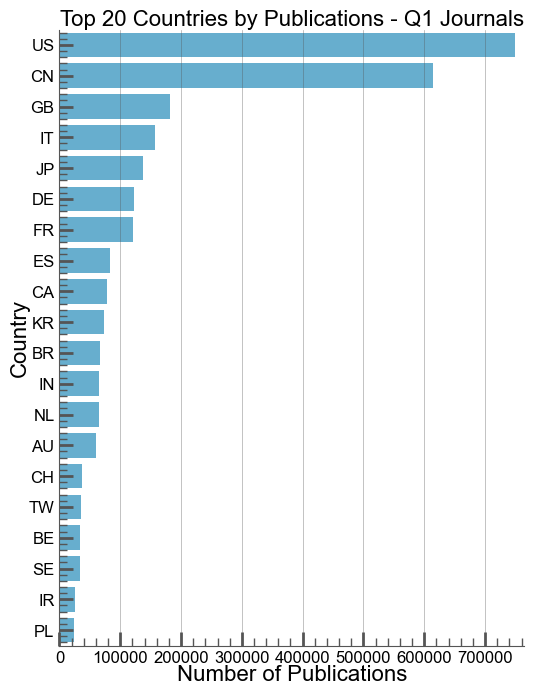

<Figure size 640x480 with 0 Axes>

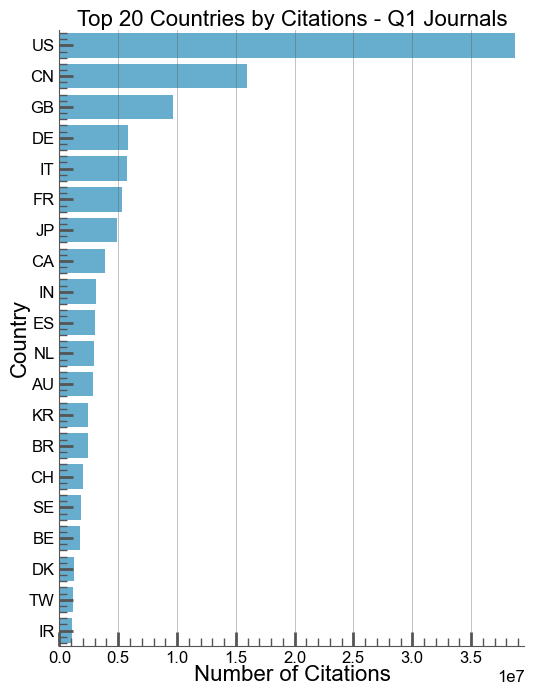

<Figure size 640x480 with 0 Axes>

In [12]:
top20_publications = group_countries_sum.sort("n_publications", descending=True).head(20)

with aq.load_theme("scientific"):
    plt.figure(figsize=(6,8))
    sns.barplot(
        data=top20_publications,
        x="n_publications",
        y="country_name",
        orient="h"
    )
    plt.ylabel("Country", fontsize=16)
    plt.xlabel("Number of Publications", fontsize=16)
    plt.title("Top 20 Countries by Publications - Q1 Journals", fontsize=16)
    plt.show()


top20_citations = group_countries_sum.sort("total_citations", descending=True).head(20)

with aq.load_theme("scientific"):
    plt.figure(figsize=(6,8))
    sns.barplot(
        data=top20_citations,
        x="total_citations",
        y="country_name",
        orient="h"
    )
    plt.ylabel("Country", fontsize=16)
    plt.xlabel("Number of Citations", fontsize=16)
    plt.title("Top 20 Countries by Citations - Q1 Journals", fontsize=16)
    plt.show()


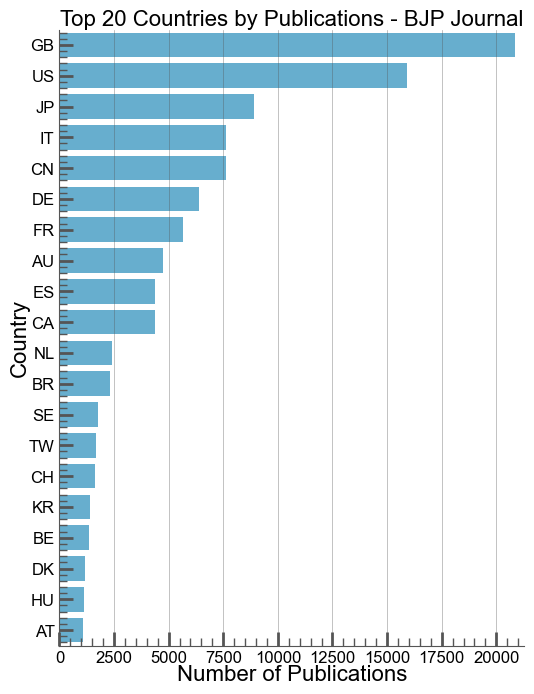

<Figure size 640x480 with 0 Axes>

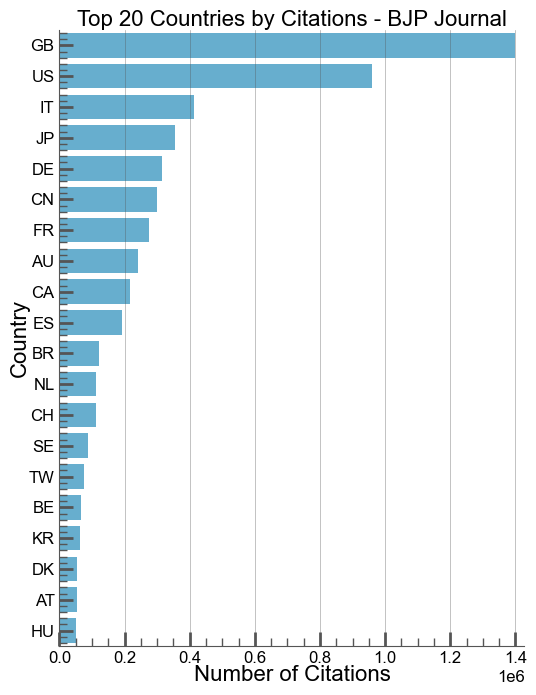

In [13]:
top20_publications_bjp = group_countries_sum_bjp.sort("n_publications", descending=True).head(20)

with aq.load_theme("scientific"):
    plt.figure(figsize=(6,8))
    sns.barplot(
        data=top20_publications_bjp,
        x="n_publications",
        y="country_name",
        orient="h"
    )
    plt.ylabel("Country", fontsize=16)
    plt.xlabel("Number of Publications", fontsize=16)
    plt.title("Top 20 Countries by Publications - BJP Journal", fontsize=16)
    plt.show()


top20_citations_bjp = group_countries_sum_bjp.sort("total_citations", descending=True).head(20)

with aq.load_theme("scientific"):
    plt.figure(figsize=(6,8))
    sns.barplot(
        data=top20_citations_bjp,
        x="total_citations",
        y="country_name",
        orient="h"
    )
    plt.ylabel("Country", fontsize=16)
    plt.xlabel("Number of Citations", fontsize=16)
    plt.title("Top 20 Countries by Citations - BJP Journal", fontsize=16)
    plt.show()


In [14]:

cols_to_stats = [
    "cited_by_count",
    "countries_distinct_count",
    "mncs" 
]

agg_exprs = []
for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))


group_Ncountries = (
    works
    .group_by("countries_distinct_count")
    .agg(*agg_exprs)
    .sort("countries_distinct_count")
)

group_Ncountries_bjp = (
    works_bjp
    .group_by("countries_distinct_count")
    .agg(*agg_exprs)
    .sort("countries_distinct_count")
)

group_Ncountries = group_Ncountries.sort("countries_distinct_count", descending=False)
group_Ncountires_bjp = group_Ncountries_bjp.sort("countries_distinct_count", descending=False)

print(group_countries_bjp)

shape: (119, 18)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ country_na ┆ cited_by_c ┆ cited_by_c ┆ cited_by_ ┆ … ┆ mncs_medi ┆ mncs_p2_5 ┆ mncs_p97_ ┆ count │
│ me         ┆ ount_mean  ┆ ount_media ┆ count_p2_ ┆   ┆ an        ┆ ---       ┆ 5         ┆ ---   │
│ ---        ┆ ---        ┆ n          ┆ 5         ┆   ┆ ---       ┆ f64       ┆ ---       ┆ i64   │
│ str        ┆ f64        ┆ ---        ┆ ---       ┆   ┆ f64       ┆           ┆ f64       ┆       │
│            ┆            ┆ f64        ┆ f64       ┆   ┆           ┆           ┆           ┆       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ GB         ┆ 67.067028  ┆ 34.0       ┆ 1.0       ┆ … ┆ 0.836549  ┆ 0.025754  ┆ 10.702047 ┆ 20872 │
│ US         ┆ 60.210328  ┆ 36.0       ┆ 0.0       ┆ … ┆ 0.886481  ┆ 0.0       ┆ 7.377168  ┆ 15918 │
│ JP         ┆ 39.885128  ┆ 27.0       ┆ 3.0       ┆ … ┆ 0.612303  ┆ 0.074

<Figure size 640x480 with 0 Axes>

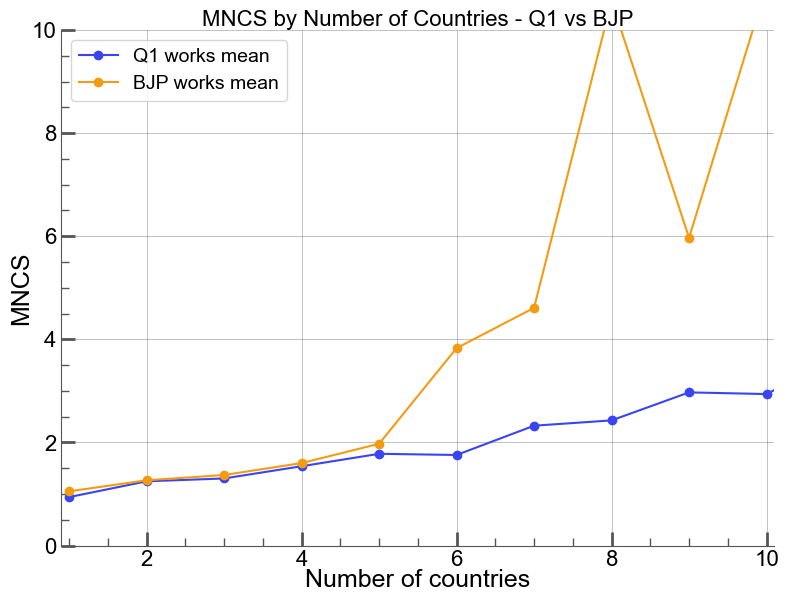

In [15]:
countries_counts_q1 = group_Ncountries["countries_distinct_count"].to_numpy()
mean_q1 = group_Ncountries["mncs_mean"].to_numpy()
median_q1 = group_Ncountries["mncs_median"].to_numpy()
low_q1 = group_Ncountries["mncs_p2_5"].to_numpy()
high_q1 = group_Ncountries["mncs_p97_5"].to_numpy()


countries_counts_bjp = group_Ncountries_bjp["countries_distinct_count"].to_numpy()
mean_bjp = group_Ncountries_bjp["mncs_mean"].to_numpy()
median_bjp = group_Ncountries_bjp["mncs_median"].to_numpy()
low_bjp = group_Ncountries_bjp["mncs_p2_5"].to_numpy()
high_bjp = group_Ncountries_bjp["mncs_p97_5"].to_numpy()

all_counts = sorted(set(countries_counts_q1) | set(countries_counts_bjp))

def align_values(counts, mean,median, low, high, all_counts):
    mean_aligned, median_aligned,low_aligned, high_aligned = [], [], [],[]
    mapping = {c:(m,m2,l,h) for c,m,m2,l,h in zip(counts, mean, median, low, high)}
    for c in all_counts:
        if c in mapping:
            mean_aligned.append(mapping[c][0])
            median_aligned.append(mapping[c][1])
            low_aligned.append(mapping[c][2])
            high_aligned.append(mapping[c][3])
        else:
            mean_aligned.append(np.nan)
            median_aligned.append(np.nan)
            low_aligned.append(np.nan)
            high_aligned.append(np.nan)
    
    return np.array(mean_aligned),np.array(median_aligned), np.array(low_aligned), np.array(high_aligned)

mean_q1, median_q1,low_q1, high_q1 = align_values(countries_counts_q1, mean_q1,median_q1, low_q1, high_q1, all_counts)
mean_bjp, median_bjp, low_bjp, high_bjp = align_values(countries_counts_bjp, mean_bjp,median_bjp, low_bjp, high_bjp, all_counts)


with aq.load_theme("scientific"):
    plt.figure(figsize=(8,6))

    plt.plot(all_counts, mean_q1, color="#3944f3", marker="o", label="Q1 works mean")
    #plt.plot(all_counts, median_q1, color="#39daf3", marker="o", label="Q1 works median")
    #plt.fill_between(all_counts, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(all_counts, mean_bjp, color="#f39c12", marker="o", label="BJP works mean")
    #plt.plot(all_counts, median_bjp, color="#f31212", marker="o", label="BJP works median")
    #plt.fill_between(all_counts, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Number of countries", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xlim(0.9, 10.1)
    plt.ylim(0, 10)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.title("MNCS by Number of Countries - Q1 vs BJP", fontsize=16)
    plt.show()


In [16]:
r_pearson, p_pearson = st.pearsonr(works["countries_distinct_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["countries_distinct_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.061, p-value = 0.000
Spearman: rho = 0.148, p-value = 0.000


In [17]:
group_countriesyears = (
    group_countriesyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("country_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("country_name"),
        cum_count=pl.col("count").cum_sum().over("country_name")
    ) 
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
)

group_countriesyears_bjp = (
    group_countriesyears_bjp
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("country_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("country_name"),
        cum_count=pl.col("count").cum_sum().over("country_name")
    ) 
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
)

<Figure size 640x480 with 0 Axes>

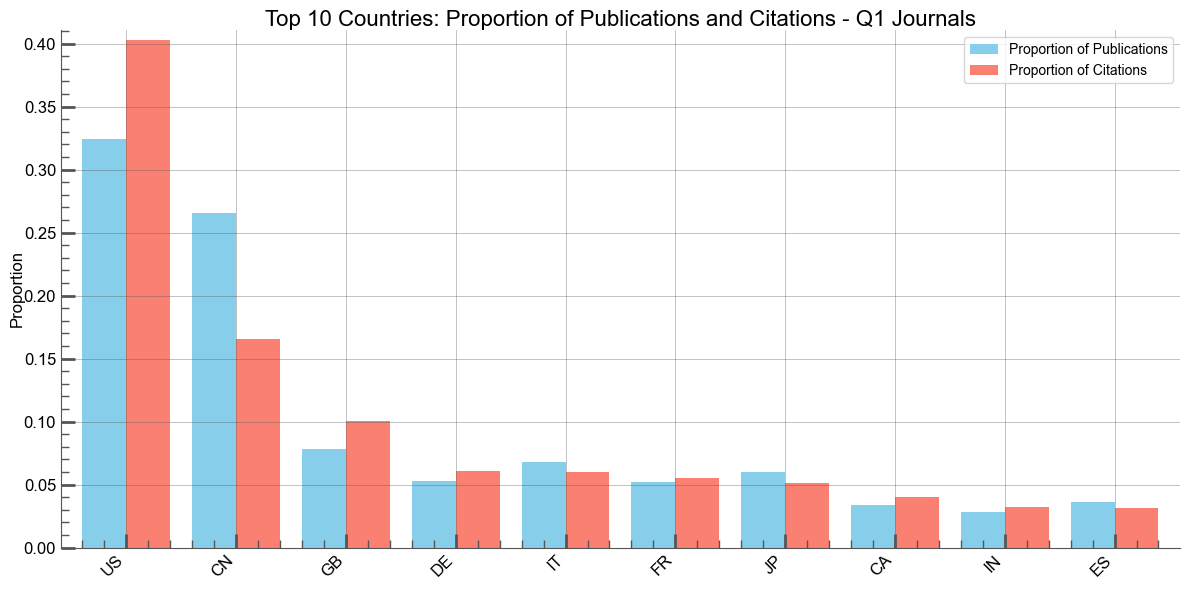

In [18]:
top_countries = (
    group_countries_sum.sort("total_citations", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries_sum.filter(pl.col("country_name").is_in(top_countries)).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["n_publications"] / df_top_countries["n_publications"].sum()
df_top_countries["prop_citations"] = df_top_countries["total_citations"] / df_top_countries["total_citations"].sum()


fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations - Q1 Journals", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

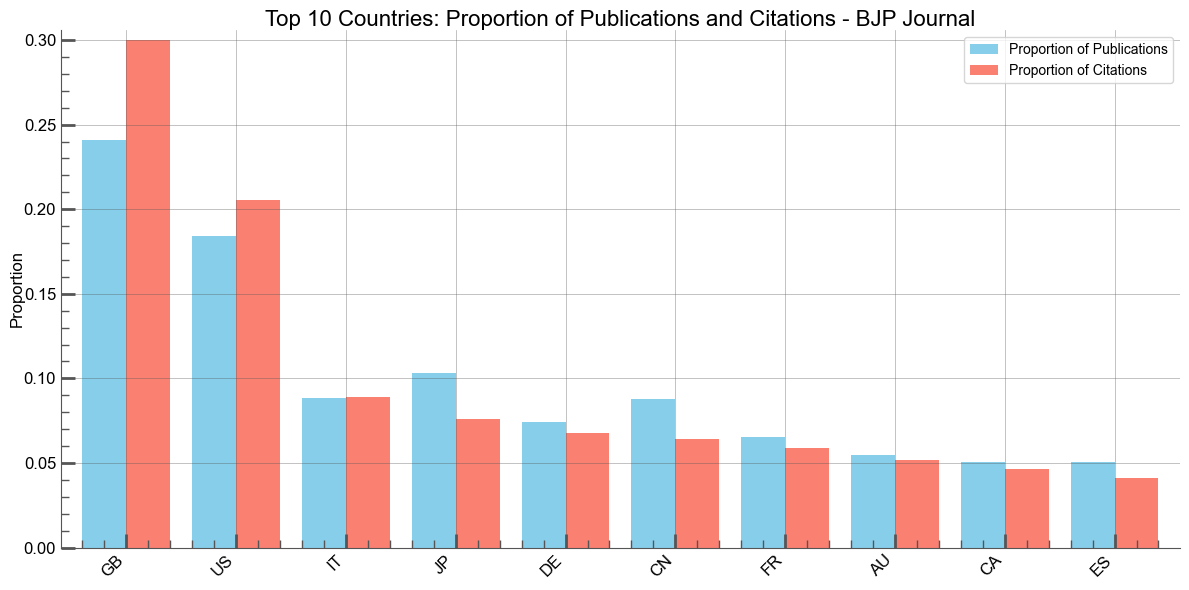

In [19]:
top_countries = (
    group_countries_sum_bjp.sort("total_citations", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries_sum_bjp.filter(pl.col("country_name").is_in(top_countries)).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["n_publications"] / df_top_countries["n_publications"].sum()
df_top_countries["prop_citations"] = df_top_countries["total_citations"] / df_top_countries["total_citations"].sum()


fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations - BJP Journal", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

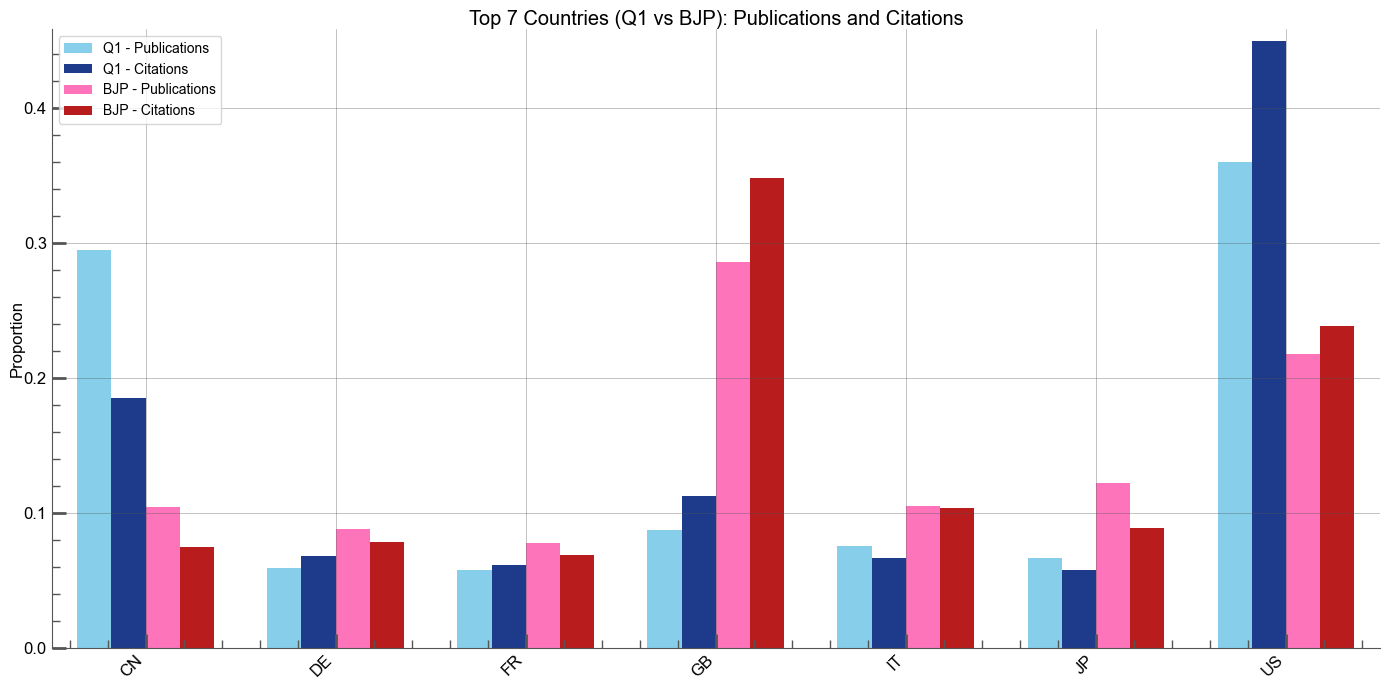

In [20]:
top_countries_q1 = (
    group_countries.sort("count", descending=True)
                   .head(7)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_q1 = group_countries.filter(pl.col("country_name").is_in(top_countries_q1)).to_pandas()
df_q1["prop_publications"] = df_q1["count"] / df_q1["count"].sum()
df_q1["prop_citations"] = df_q1["cited_by_count_mean"] * df_q1["count"]
df_q1["prop_citations"] /= df_q1["prop_citations"].sum()
df_q1["source"] = "Q1"

top_countries_bjp = (
    group_countries_bjp.sort("count", descending=True)
                       .head(7)
                       .select("country_name")
                       .to_series()
                       .to_list()
)

df_bjp = group_countries_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)).to_pandas()
df_bjp["prop_publications"] = df_bjp["count"] / df_bjp["count"].sum()
df_bjp["prop_citations"] = df_bjp["cited_by_count_mean"] * df_bjp["count"]
df_bjp["prop_citations"] /= df_bjp["prop_citations"].sum()
df_bjp["source"] = "BJP"

df_all = pd.concat([df_q1, df_bjp], ignore_index=True)

fig, ax = plt.subplots(figsize=(14, 7))

countries = sorted(set(df_all["country_name"]))
x = range(len(countries))
width = 0.18  

def get_vals(df, metric, countries):
    return [df.loc[df["country_name"] == c, metric].values[0] if c in df["country_name"].values else 0 for c in countries]

df_q1_sub = df_all[df_all["source"] == "Q1"]
df_bjp_sub = df_all[df_all["source"] == "BJP"]

ax.bar([i - 1.5*width for i in x], get_vals(df_q1_sub, "prop_publications", countries), 
       width=width, label="Q1 - Publications", color="#87CEEB")  
ax.bar([i - 0.5*width for i in x], get_vals(df_q1_sub, "prop_citations", countries), 
       width=width, label="Q1 - Citations", color="#1E3A8A")  

ax.bar([i + 0.5*width for i in x], get_vals(df_bjp_sub, "prop_publications", countries), 
       width=width, label="BJP - Publications", color="#FD74BB")  
ax.bar([i + 1.5*width for i in x], get_vals(df_bjp_sub, "prop_citations", countries), 
       width=width, label="BJP - Citations", color="#B91C1C")  

ax.set_xticks(list(x))
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 7 Countries (Q1 vs BJP): Publications and Citations")
ax.legend()
plt.tight_layout()
plt.show()


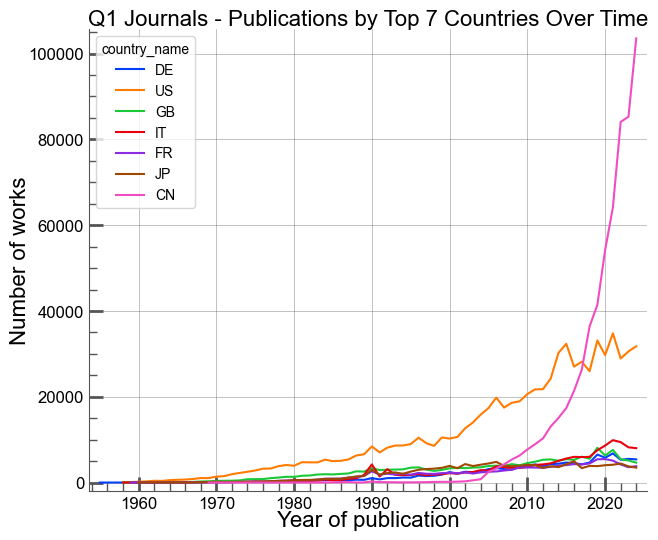

In [21]:

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_countriesyears.filter(pl.col("country_name").is_in(top_countries_q1)), x = "year", y = "count", hue = "country_name", palette = "bright")
    #plt.xlim(1980, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.title("Q1 Journals - Publications by Top 7 Countries Over Time", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

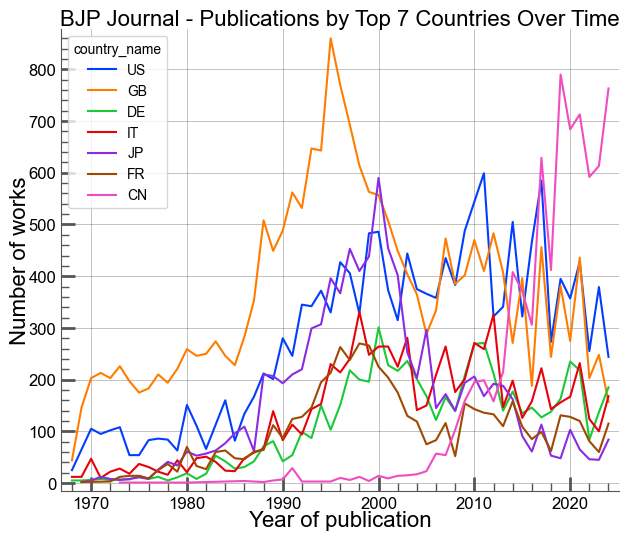

In [22]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_countriesyears_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)), x = "year", y = "count", hue = "country_name", palette = "bright")
    #plt.xlim(1980, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.title("BJP Journal - Publications by Top 7 Countries Over Time", fontsize=16)
    plt.show()

In [25]:
countries_col = [f"country_{i}" for i in range(1, 193)]

countries2= (
    works
    .select(["year", "cited_by_count","mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count","mncs"], 
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)


countries_col = [f"country_{i}" for i in range(1, 121)]

countries2_bjp= (
    works_bjp
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)



ColumnNotFoundError: unable to find column "countries_distinct_count"; valid columns: ["index_work", "cited_by_count", "mncs", "country_name", "count", "age"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["index_work", "cited_by_count", "mncs", "country_name", ...]; PROJECT */6 COLUMNS

In [26]:
cols_to_stats = [
    "cited_by_count",
    "age",
    "count",
    "mncs"
]

agg_exprs = []

for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.25).alias(f"{col}_p25"))
    agg_exprs.append(pl.col(col).quantile(0.75).alias(f"{col}_p75"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))
    
group_countries = (
    countries2
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(
        count=pl.col("count").sum(),
         *agg_exprs
         )
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries_bjp = (
    countries2_bjp
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(count=pl.col("count").sum(),
         *agg_exprs
         )  
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries = group_countries.sort("count", descending=True)
group_countires_bjp = group_countries_bjp.sort("count", descending=True)

In [27]:

top7_countries = group_countries.head(7)

countries_q1_ci = top7_countries["country_name"].to_list()
mean_q1_ci = top7_countries["age_mean"].to_numpy()
median_q1_ci = top7_countries["age_median"].to_numpy()
vlow_q1 = top7_countries["age_p2_5"].to_numpy()
vhigh_q1 = top7_countries["age_p97_5"].to_numpy()
low_q1 = top7_countries["age_p25"].to_numpy()
high_q1 = top7_countries["age_p75"].to_numpy()


top7_countries_bjp = group_countries_bjp.head(7)

countries_q1_ci_bjp = top7_countries_bjp["country_name"].to_list()
mean_q1_ci_bjp = top7_countries_bjp["age_mean"].to_numpy()
median_q1_ci_bjp = top7_countries_bjp["age_median"].to_numpy()
vlow_q1_bjp = top7_countries_bjp["age_p2_5"].to_numpy()
vhigh_q1_bjp = top7_countries_bjp["age_p97_5"].to_numpy()
low_q1_bjp = top7_countries_bjp["age_p25"].to_numpy()
high_q1_bjp = top7_countries_bjp["age_p75"].to_numpy()



<Figure size 640x480 with 0 Axes>

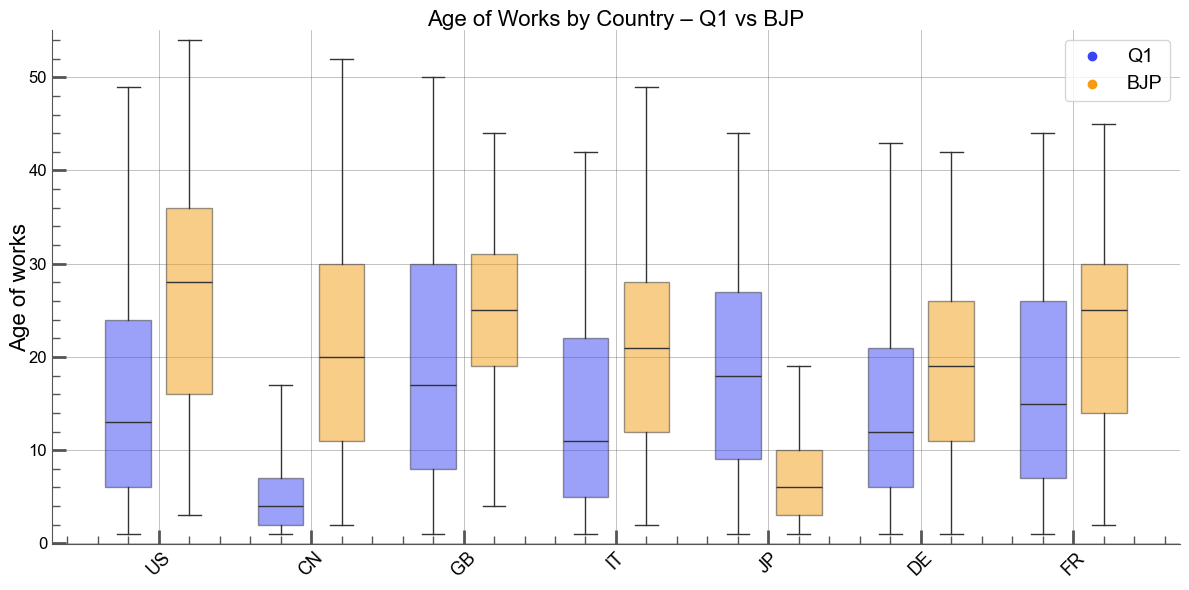

In [28]:

q1_stats_list = []
bjp_stats_list = []

for i in range(len(countries_q1_ci)):
    q1_stats_list.append({
        'med': median_q1_ci[i],
        'q1': low_q1[i],
        'q3': high_q1[i],
        'whislo': vlow_q1[i],
        'whishi': vhigh_q1[i],
        'fliers': []
    })
    bjp_stats_list.append({
        'med': median_q1_ci_bjp[i],
        'q1': low_q1_bjp[i],
        'q3': high_q1_bjp[i],
        'whislo': vlow_q1_bjp[i],
        'whishi': vhigh_q1_bjp[i],
        'fliers': []
    })

x = np.arange(len(countries_q1_ci))
positions_q1 = x - 0.2
positions_bjp = x + 0.2

with aq.load_theme("scientific"):
    fig, ax = plt.subplots(figsize=(12,6))

    bp1 = ax.bxp(q1_stats_list, positions=positions_q1, widths=0.3, patch_artist=True, showfliers=False)
    for box in bp1['boxes']:
        box.set(facecolor="#3944f3", alpha=0.5)

    bp2 = ax.bxp(bjp_stats_list, positions=positions_bjp, widths=0.3, patch_artist=True, showfliers=False)
    for box in bp2['boxes']:
        box.set(facecolor="#f39c12", alpha=0.5)

    ax.set_xticks(x)
    ax.set_xticklabels(countries_q1_ci, rotation=45, fontsize=13)
    ax.set_ylabel("Age of works", fontsize=16)
    ax.set_title("Age of Works by Country – Q1 vs BJP", fontsize=16)

    ax.scatter([], [], color="#3944f3", label="Q1")
    ax.scatter([], [], color="#f39c12", label="BJP")
    ax.legend(fontsize=14)

    fig.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

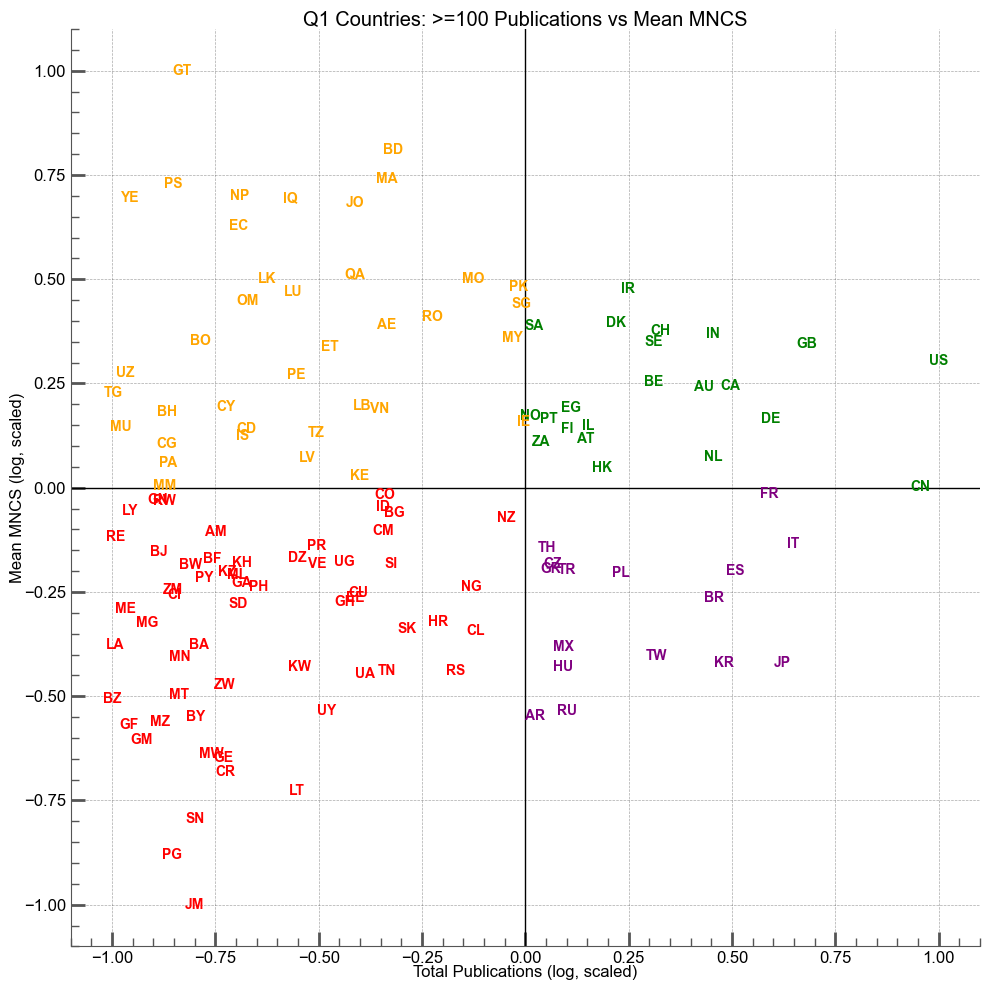

In [29]:
group_countries_filtered = group_countries.filter(pl.col("count") >= 100)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("mncs_mean").log().alias("mncs_log")
)

pub_log = group_countries_filtered ["count_log"].to_numpy()
x_min = np.min(pub_log)
x_max = np.max(pub_log)

mncs_log = group_countries_filtered["mncs_log"].to_numpy()
y_min = np.min(mncs_log)
y_max = np.max(mncs_log)


group_countries_filtered = group_countries_filtered.with_columns([
    ((pl.col("count_log") - x_min) / (x_max - x_min) * 2 - 1).alias("x_viz"),
    ((pl.col("mncs_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
])

plt.figure(figsize=(10, 10))

for name, x, y in zip(
    group_countries_filtered["country_name"],
    group_countries_filtered["x_viz"],
    group_countries_filtered["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.axvline(0, color="black", linewidth=1)
plt.axhline(0, color="black", linewidth=1)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Total Publications (log, scaled)")
plt.ylabel("Mean MNCS (log, scaled)")

plt.title("Q1 Countries: >=100 Publications vs Mean MNCS")

plt.tight_layout()
plt.show()


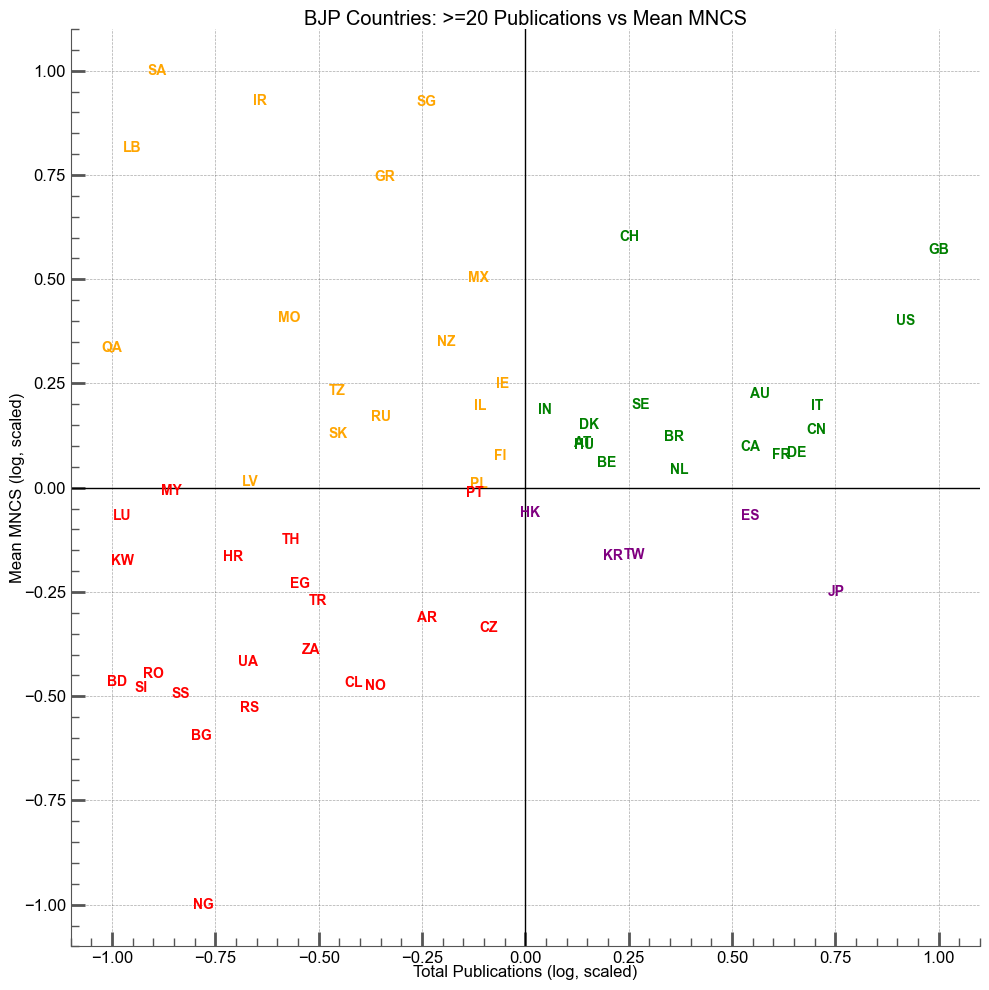

In [30]:
group_countries_filtered = group_countries_bjp.filter(pl.col("count") > 20)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("mncs_mean").log().alias("mncs_log")
)

pub_log = group_countries_filtered ["count_log"].to_numpy()
x_min = np.min(pub_log)
x_max = np.max(pub_log)

mncs_log = group_countries_filtered["mncs_log"].to_numpy()
y_min = np.min(mncs_log)
y_max = np.max(mncs_log)


group_countries_filtered = group_countries_filtered.with_columns([
    ((pl.col("count_log") - x_min) / (x_max - x_min) * 2 - 1).alias("x_viz"),
    ((pl.col("mncs_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
])

plt.figure(figsize=(10, 10))

for name, x, y in zip(
    group_countries_filtered["country_name"],
    group_countries_filtered["x_viz"],
    group_countries_filtered["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.axvline(0, color="black", linewidth=1)
plt.axhline(0, color="black", linewidth=1)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Total Publications (log, scaled)")
plt.ylabel("Mean MNCS (log, scaled)")

plt.title("BJP Countries: >=20 Publications vs Mean MNCS")

plt.tight_layout()
plt.show()


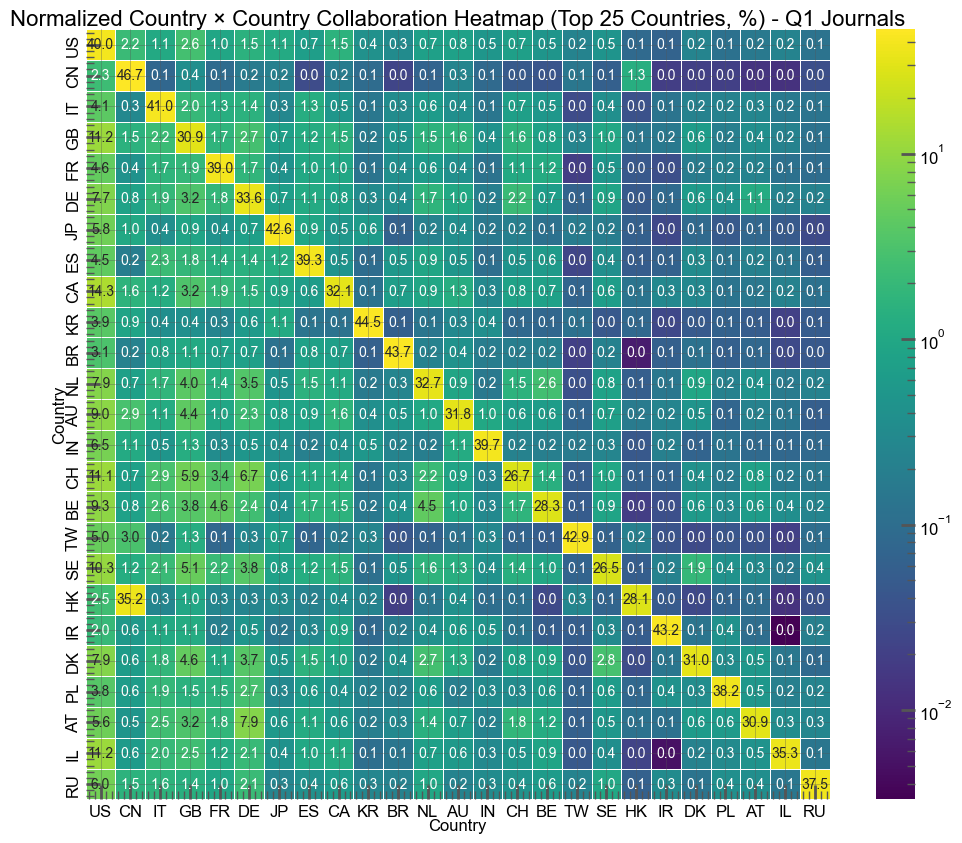

In [31]:
import itertools
import matplotlib


countries_col_q1 = [f"country_{i}" for i in range(1, 193)]

pairs_counter = {}
country_collab_totals = {}     
country_collab_totals_top25 = {}  

for row in works.select(countries_col_q1).iter_rows(named=True):
    countries = [row[c] for c in countries_col_q1 if row[c] is not None]
    if len(countries) >= 2:
        for pair in itertools.combinations(sorted(countries), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            country_collab_totals[pair[0]] = country_collab_totals.get(pair[0], 0) + 1
            country_collab_totals[pair[1]] = country_collab_totals.get(pair[1], 0) + 1

top_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_countries = [c for c, _ in top_countries]

heatmap_df = pd.DataFrame(0, index=top_countries, columns=top_countries, dtype=float)

for (c1, c2), count in pairs_counter.items():
    if c1 in top_countries and c2 in top_countries:
        heatmap_df.loc[c1, c2] = count
        heatmap_df.loc[c2, c1] = count

for c in top_countries:
    total = country_collab_totals[c]  
    if total > 0:
        heatmap_df.loc[c, :] = heatmap_df.loc[c, :] / total * 100

plt.figure(figsize=(12,10))
sns.heatmap(
    heatmap_df,
    cmap="viridis",          
    norm=matplotlib.colors.LogNorm(vmin=heatmap_df[heatmap_df > 0].min().min(),
                                   vmax=heatmap_df.max().max()),  
    linewidths=0.5,
    annot=True,
    fmt=".1f"
)
plt.title("Normalized Country × Country Collaboration Heatmap (Top 25 Countries, %) - Q1 Journals", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Country")
plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_20808\4174563176.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


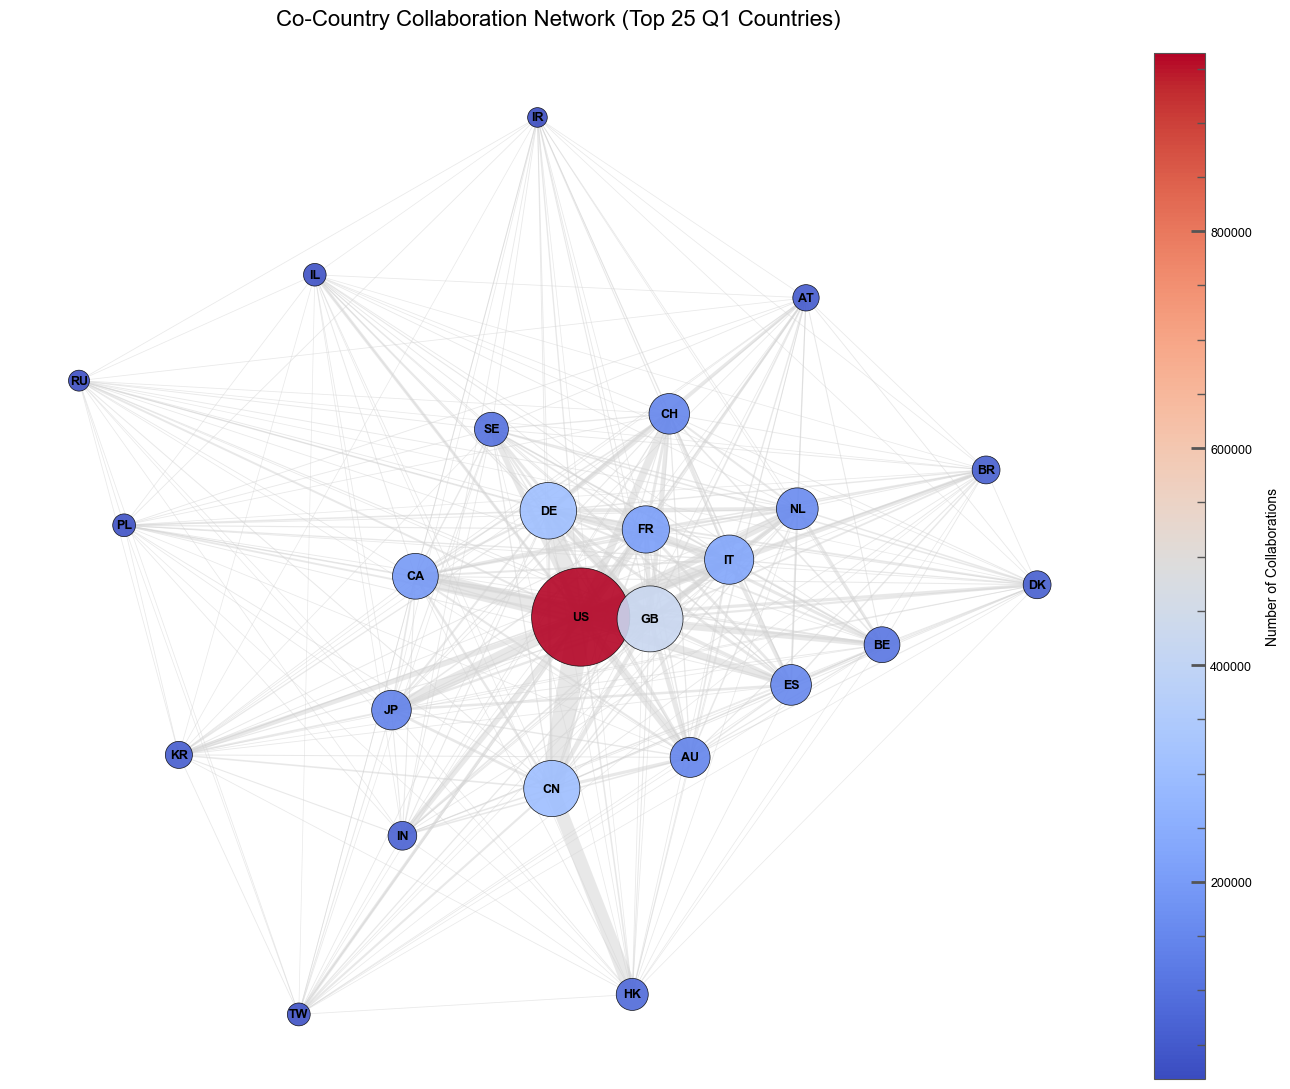

In [32]:
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib import cm

#plot not perfect, diff colors ?

G = nx.Graph()
for (c1, c2), count in pairs_counter.items():
    if c1 != c2 and c1 in top_countries and c2 in top_countries:
        G.add_edge(c1, c2, weight=count)

node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)  

edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)  # 0.5 à 5 px


cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
colors = cmap(norm(node_vals))

pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)


fig, ax = plt.subplots(figsize=(13, 11))


nx.draw_networkx_edges(
    G, pos,
    ax=ax,
    width=edge_weights,
    edge_color='lightgray',
    alpha=0.5
)


nx.draw_networkx_nodes(
    G, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5
)


nx.draw_networkx_labels(
    G, pos,
    ax=ax,
    font_size=9,
    font_weight='bold'
)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Number of Collaborations", fontsize=10, labelpad=10)


ax.set_title("Co-Country Collaboration Network (Top 25 Q1 Countries)", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()



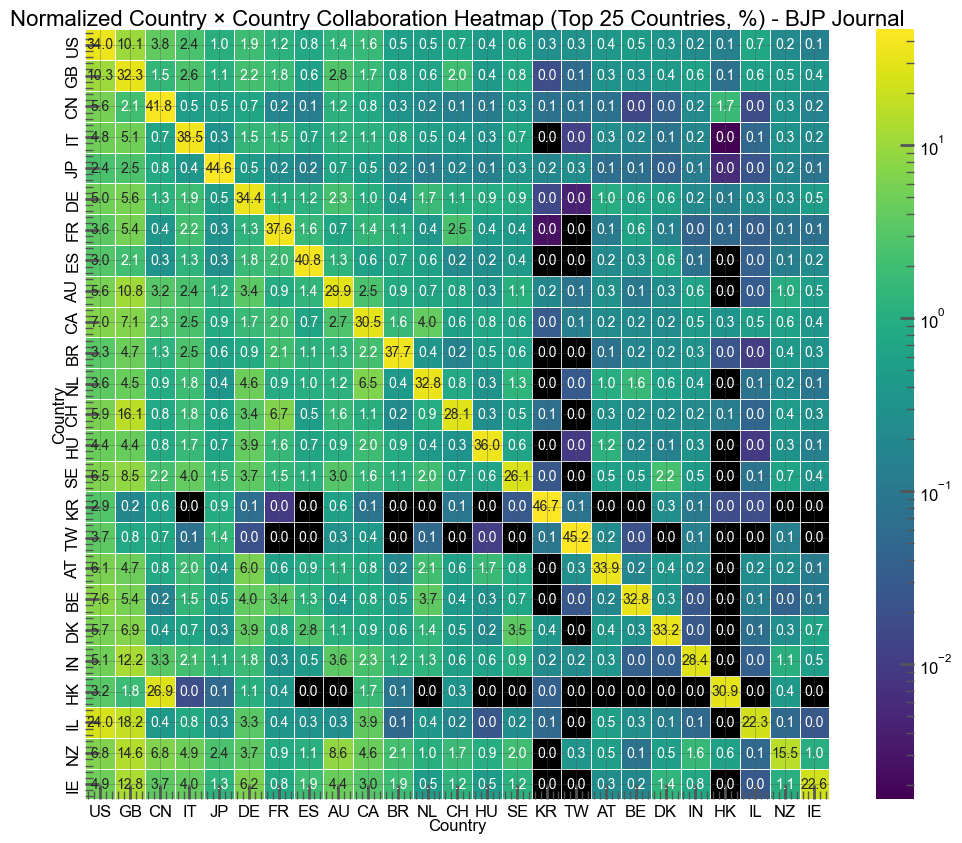

In [33]:
countries_col_bjp = [f"country_{i}" for i in range(1, 121)]

pairs_counter = {}
country_collab_totals = {}

for row in works_bjp.select(countries_col_bjp).iter_rows(named=True):
    countries = [row[c] for c in countries_col_bjp if row[c] is not None]
    if len(countries) >= 2:
        for pair in itertools.combinations(sorted(countries), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            country_collab_totals[pair[0]] = country_collab_totals.get(pair[0], 0) + 1
            country_collab_totals[pair[1]] = country_collab_totals.get(pair[1], 0) + 1

top_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_countries = [c for c, _ in top_countries]

top2_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)
top2_countries = [c for c, _ in top2_countries]

heatmap_df = pd.DataFrame(0, index=top_countries, columns=top_countries, dtype=float)

for (c1, c2), count in pairs_counter.items():
    if c1 in top_countries and c2 in top_countries:
        heatmap_df.loc[c1, c2] = count
        heatmap_df.loc[c2, c1] = count  

for c in top_countries:
    total = country_collab_totals[c]
    if total > 0:
        heatmap_df.loc[c, :] = heatmap_df.loc[c, :] / total * 100  

plt.figure(figsize=(12,10))

mask = (heatmap_df == 0)

ax = sns.heatmap(
    heatmap_df,
    cmap="viridis",
    norm=matplotlib.colors.LogNorm(
        vmin=heatmap_df[heatmap_df > 0].min().min(),
        vmax=heatmap_df.max().max()
    ),
    linewidths=0.5,
    linecolor="white",      
    annot=True,
    fmt=".1f",
    mask=mask,
)

for i in range(heatmap_df.shape[0]):
    for j in range(heatmap_df.shape[1]):
        if heatmap_df.iloc[i, j] == 0:
            rect = plt.Rectangle((j, i), 1, 1, facecolor="black", edgecolor="white", lw=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, "0.0", ha="center", va="center", color="white")

plt.title("Normalized Country × Country Collaboration Heatmap (Top 25 Countries, %) - BJP Journal", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Country")
plt.show()




C:\Users\noahr\AppData\Local\Temp\ipykernel_20808\4002355898.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


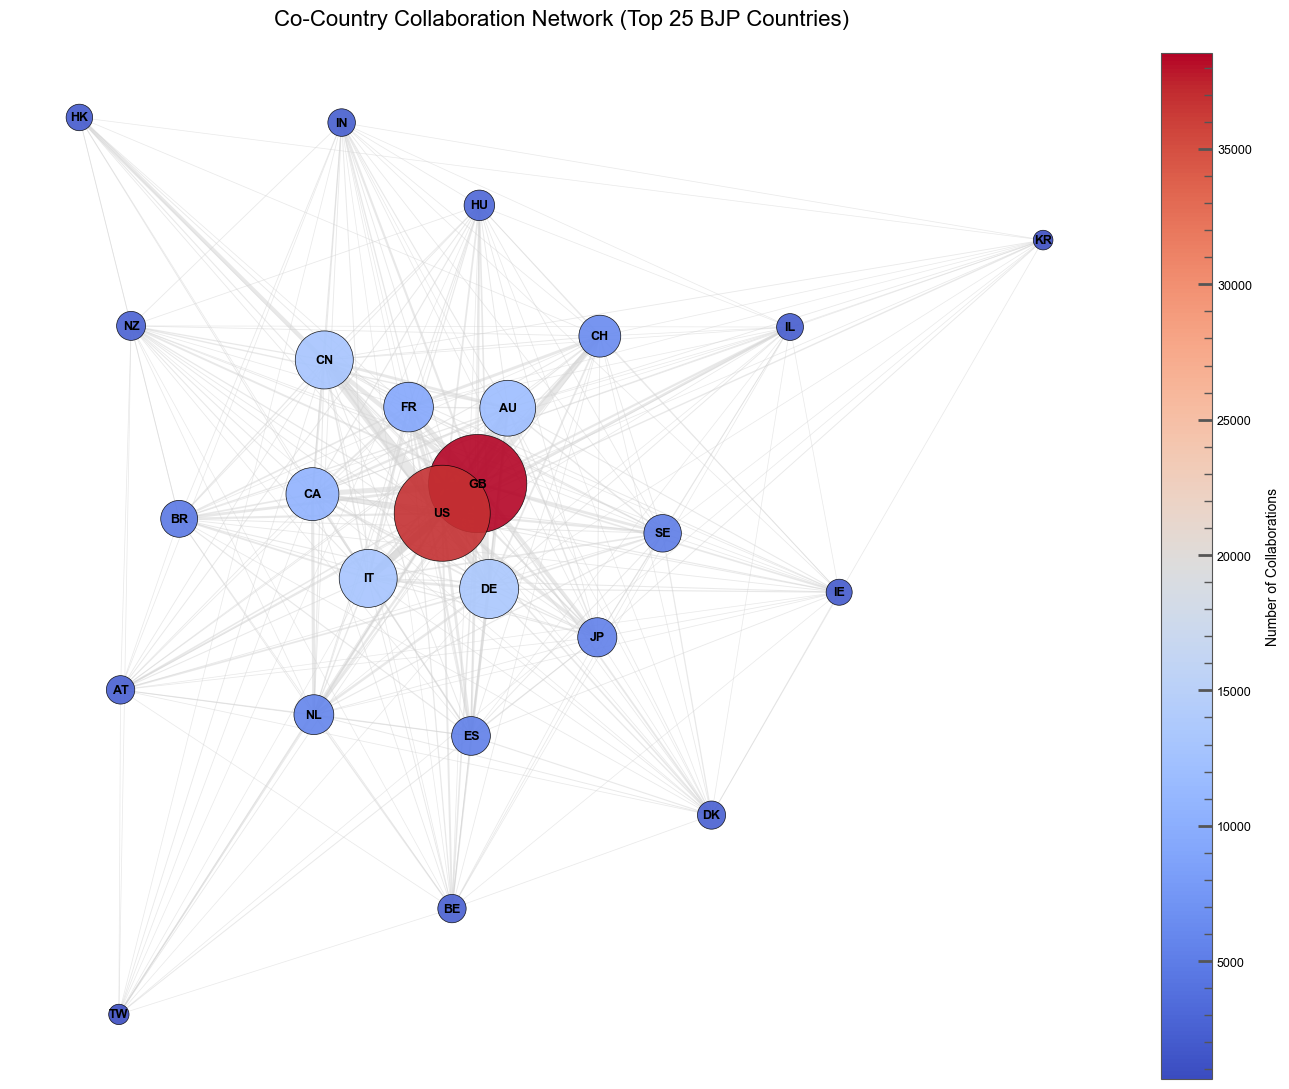

In [34]:

#plot not perfect, diff colors ?
G = nx.Graph()
for (c1, c2), count in pairs_counter.items():
    if c1 != c2 and c1 in top_countries and c2 in top_countries:
        G.add_edge(c1, c2, weight=count)

node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)  

edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)  # 0.5 à 5 px


cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
colors = cmap(norm(node_vals))

pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)


fig, ax = plt.subplots(figsize=(13, 11))


nx.draw_networkx_edges(
    G, pos,
    ax=ax,
    width=edge_weights,
    edge_color='lightgray',
    alpha=0.5
)


nx.draw_networkx_nodes(
    G, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5
)


nx.draw_networkx_labels(
    G, pos,
    ax=ax,
    font_size=9,
    font_weight='bold'
)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Number of Collaborations", fontsize=10, labelpad=10)


ax.set_title("Co-Country Collaboration Network (Top 25 BJP Countries)", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()



173 59


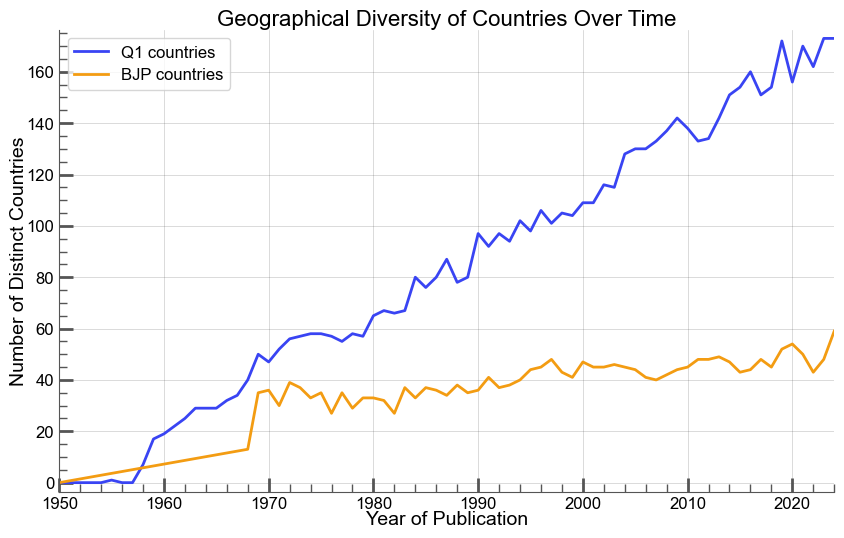

In [35]:
countries_col_q1 = [f"country_{i}" for i in range(1, 193)]
countries_col_bjp = [f"country_{i}" for i in range(1, 121)]

def countries_distinct_yearly_iter(df, countries_col):
    years = sorted(df["year"].unique().to_list())
    countries_count = []

    for y in years:
        df_year = df.filter(pl.col("year") == y)
        country_set = set()
        for col in countries_col:
            country_set.update(df_year[col].drop_nulls().to_list())
        countries_count.append(len(country_set))

    return years, countries_count

years_q1, countries_count_q1 = countries_distinct_yearly_iter(works, countries_col_q1)
years_bjp, countries_count_bjp = countries_distinct_yearly_iter(works_bjp, countries_col_bjp)

print(max(countries_count_q1),max(countries_count_bjp))

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, countries_count_q1, color="#3944f3", label="Q1 countries", linewidth=2)
    plt.plot(years_bjp, countries_count_bjp, color="#f39c12", label="BJP countries", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Number of Distinct Countries", fontsize=14)
    plt.title("Geographical Diversity of Countries Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(1950,2024)
    plt.show()

In [36]:

countries_col_q1 = [f"country_{i}" for i in range(1, 193)]
countries_col_bjp = [f"country_{i}" for i in range(1, 120)]
institutions_col_q1 = [f"institution_{i}" for i in range(1, 193)] 
institutions_col_bjp = [f"institution_{i}" for i in range(1, 127)]  

def collaboration_indicators_safe(df, countries_col, institutions_col, cited_col="cited_by_count"):
    years = sorted(df["year"].unique().to_list())
    pct_multinational = []
    pct_multi_institutional = []
    mean_citations_multi_country = []
    mean_citations_single_country = []
    mean_citations_multi_institution = []
    mean_citations_single_institution = []

    for y in years:
        df_y = df.filter(pl.col("year") == y)
        n_articles = df_y.height
        multi_country_count = 0
        multi_institution_count = 0
        citations_multi = []
        citations_single = []
        citations_multi_institution = []
        citations_single_institution = []


        for row in df_y.iter_rows(named=True):
            n_countries = len(set(c for c in (row[c] for c in countries_col) if c is not None))
            n_institutions = len(set(i for i in (row[i] for i in institutions_col) if i is not None))
            cited = row[cited_col]

            if n_countries >= 2:
                multi_country_count += 1
                citations_multi.append(cited)
            else:
                citations_single.append(cited)
            
            if n_institutions >= 2:
                multi_institution_count += 1
                citations_multi_institution.append(cited)
            else:
                citations_single_institution.append(cited)

        pct_multinational.append((multi_country_count / n_articles *100) if n_articles else 0)
        pct_multi_institutional.append((multi_institution_count / n_articles *100) if n_articles else 0)
        mean_citations_multi_country.append(np.mean(citations_multi) if citations_multi else 0)
        mean_citations_single_country.append(np.mean(citations_single) if citations_single else 0)
        mean_citations_multi_institution.append(np.mean(citations_multi_institution) if citations_multi_institution else 0)
        mean_citations_single_institution.append(np.mean(citations_single_institution) if citations_single_institution else 0)

    return {
        "year": years,
        "pct_multinational": pct_multinational,
        "pct_multi_institutional": pct_multi_institutional,
        "mean_citations_multi_country": mean_citations_multi_country,
        "mean_citations_single_country": mean_citations_single_country,
        "mean_citations_multi_institution": mean_citations_multi_institution,
        "mean_citations_single_institution": mean_citations_single_institution
    }

q1_collab = collaboration_indicators_safe(works, countries_col_q1, institutions_col_q1)
bjp_collab = collaboration_indicators_safe(works_bjp, countries_col_bjp, institutions_col_bjp)




<Figure size 640x480 with 0 Axes>

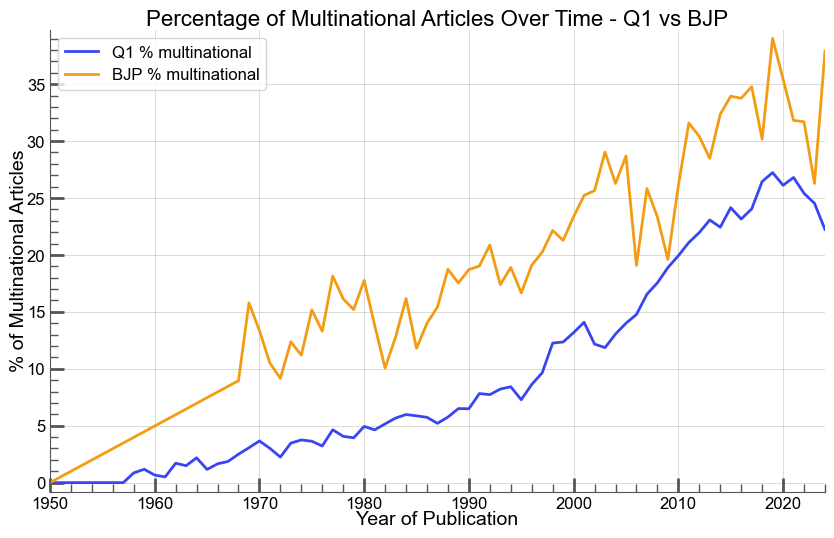

In [37]:
plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["pct_multinational"], color="#3944f3", label="Q1 % multinational", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["pct_multinational"], color="#f39c12", label="BJP % multinational", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("% of Multinational Articles", fontsize=14)
plt.title("Percentage of Multinational Articles Over Time - Q1 vs BJP", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1950,2024)
plt.show()





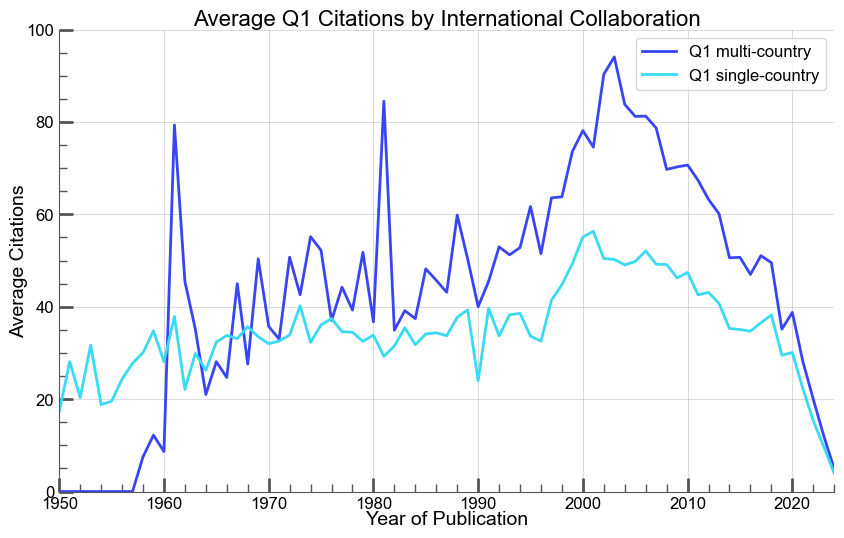

In [38]:
plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["mean_citations_multi_country"], color="#3944f3", label="Q1 multi-country", linewidth=2)
plt.plot(q1_collab["year"], q1_collab["mean_citations_single_country"], color="#39daf3", label="Q1 single-country", linewidth=2)
#plt.plot(bjp_collab["year"], bjp_collab["mean_citations_multi_country"], color="#f39c12", label="BJP multi-country", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("Average Citations", fontsize=14)
plt.ylim(0, 100)
plt.title("Average Q1 Citations by International Collaboration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1950,2024)
plt.show()

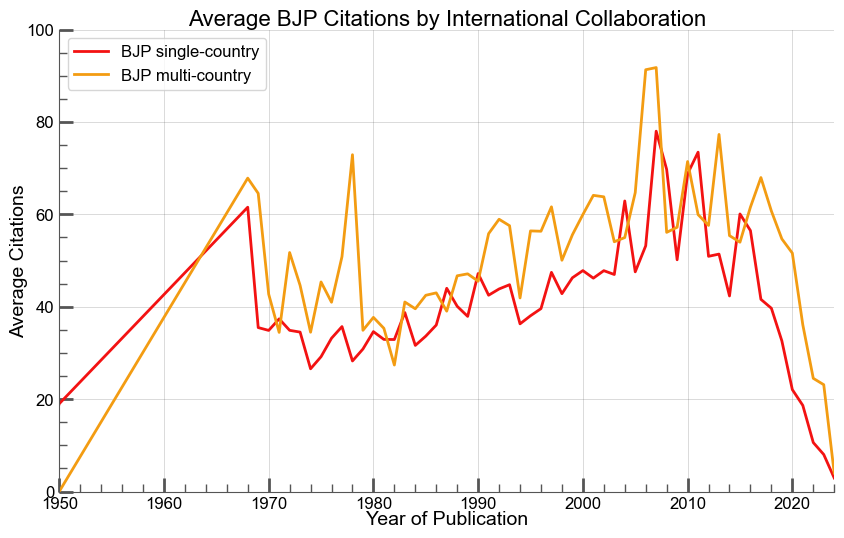

In [39]:
plt.figure(figsize=(10,6))
#plt.plot(q1_collab["year"], q1_collab["mean_citations_single_country"], color="#39daf3", label="Q1 single-country", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["mean_citations_single_country"], color="#f31212", label="BJP single-country", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["mean_citations_multi_country"], color="#f39c12", label="BJP multi-country", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("Average Citations", fontsize=14)
plt.ylim(0, 100)
plt.title("Average BJP Citations by International Collaboration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1950,2024)
plt.show()

In [72]:
institutions_col = [f"institution_{i}" for i in range(1, 193)]

institutions = (
    works
    .select(["year", "cited_by_count", "mncs", *institutions_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=institutions_col,
        index=["year", "index_work", "cited_by_count","mncs"], 
        variable_name="institution_pos",
        value_name="institution_name"
    )
    .filter(pl.col("institution_name").is_not_null())
    .with_columns([
        pl.lit(1, dtype=pl.Int8).alias("count"),
        pl.col("institution_name")
          .str.split("',", inclusive=False)
          .list.get(0)
          .str.slice(2)
          .alias("institution_simple")
    ])
)


: 

In [ ]:
institutions_col = [f"institution_{i}" for i in range(1, 127)]

institutions_bjp = (
    works_bjp
    .select(["year", "cited_by_count", "mncs", *institutions_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=institutions_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="institution_pos",
        value_name="institution_name"
    )
    .filter(pl.col("institution_name").is_not_null())
    .with_columns([
        pl.lit(1, dtype=pl.Int8).alias("count"),
        pl.col("institution_name")
          .str.split("',", inclusive=False)
          .list.get(0)
          .str.slice(2)
          .alias("institution_simple")
    ])
)


In [ ]:
group_institutionsyears = (
    institutions
    .drop("institution_pos")
    .group_by(["institution_simple", "year", "institution_name"]).sum()
    .sort("year")
)
group_institutions_sum = (
    institutions
    .select(["institution_simple", "count", "cited_by_count", "institution_name","mncs"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("cited_by_count", descending=True)

In [ ]:
group_institutionsyears_bjp = (
    institutions_bjp
    .drop("institution_pos")
    .group_by(["institution_simple", "year", "institution_name"]).sum()
    .sort("year")
)
group_institutions_sum_bjp = (
    institutions_bjp
    .select(["institution_simple", "count", "cited_by_count", "mncs", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("cited_by_count", descending=True)

In [ ]:
top_institutions = (
    group_institutions_sum
    .sort("count", descending=True)
    .head(5)
    .select("institution_simple")
    .to_series().to_list()
)
group_institutionsyears = (
    group_institutionsyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("institution_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("institution_name"),
        cum_count=pl.col("count").cum_sum().over("institution_name")
    )
    .with_columns(
       mean_mncs=pl.col("mncs")/pl.col("count"),
       mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
    .sort("count", descending=True)
)

In [ ]:
top_institutions_bjp = (
    group_institutions_sum_bjp
    .sort("count", descending=True)
    .head(5)
    .select("institution_simple")
    .to_series().to_list()
)
group_institutionsyears_bjp = (
    group_institutionsyears_bjp
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("institution_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("institution_name"),
        cum_count=pl.col("count").cum_sum().over("institution_name")
    )
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
    .sort("count", descending=True)
)

In [ ]:
cols_to_stats = [
    "cited_by_count",
    "mncs",
    "institutions_distinct_count"
]

agg_exprs = []
for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))


group_Ninstitutions = (
    works
    .group_by("institutions_distinct_count")
    .agg(*agg_exprs)
    .sort("institutions_distinct_count")
)

group_Ninstitutions_bjp = (
    works_bjp
    .group_by("institutions_distinct_count")
    .agg(*agg_exprs)
    .sort("institutions_distinct_count")
)

In [ ]:
institutions = institutions.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("institution_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("institution_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("institution_name") - pl.col("mncs")).alias("cumulative_mncs")
])

institutions = institutions.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_institutions")
)

institutions_bjp = institutions_bjp.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("institution_name") - pl.col("count")).alias("cumulative_count"),  
    (pl.col("cited_by_count").cum_sum().over("institution_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("institution_name") - pl.col("mncs")).alias("cumulative_mncs")
])

institutions_bjp = institutions_bjp.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_institutions")
)

In [ ]:

institutions_agg = institutions.group_by("index_work").agg([
    pl.col("cumulative_count").mean().alias("mean_past_contributions_institutions"),
    pl.col("mean_past_mncs_institutions").mean().alias("mean_past_mncs_institutions")
])


works = (
    works
    .sort("year")
    .with_row_count("index_work")  
    .join(institutions_agg, on="index_work", how="left")
    .with_columns([
        pl.col("mean_past_mncs_institutions").fill_null(1),
        pl.col("mean_past_contributions_institutions").fill_null(0)
    ])
)



C:\Users\noahr\AppData\Local\Temp\ipykernel_20808\838427744.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("index_work")


In [ ]:
institutions_agg_bjp = institutions_bjp.group_by("index_work").agg([
    pl.col("cumulative_count").mean().alias("mean_past_contributions_institutions"),
    pl.col("mean_past_mncs_institutions").mean().alias("mean_past_mncs_institutions")
])


works_bjp = (
    works_bjp
    .sort("year")
    .with_row_count("index_work")  
    .join(institutions_agg, on="index_work", how="left")
    .with_columns([
        pl.col("mean_past_mncs_institutions").fill_null(1),
        pl.col("mean_past_contributions_institutions").fill_null(0)
    ])
)


C:\Users\noahr\AppData\Local\Temp\ipykernel_20808\1997424204.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("index_work")


In [ ]:
group_institutions_sum_bjp["institution_simple"].to_list()

['University of Edinburgh',
 'University College London',
 'Inserm',
 'Centre National de la Recherche Scientifique',
 'University of Nottingham',
 'King\'s College London", \'https://openalex.org/I183935753\']',
 'Wellcome Trust',
 'University of Cambridge',
 'University of Bristol',
 'The University of Melbourne',
 'New Frontier',
 'University of Glasgow',
 'University of Aberdeen',
 'University of Manchester',
 'University of Naples Federico II',
 'William Harvey Research Institute',
 'Monash University',
 'Merck & Co., Inc., Rahway, NJ, USA (United States)',
 'Queen\'s Medical Centre", \'https://openalex.org/I4210137227\']',
 'National Institutes of Health',
 'Lung Institute',
 'University of Oxford',
 'Universidade de São Paulo',
 'University of Florence',
 'University of Calgary',
 'University of London',
 'The University of Sydney',
 'AstraZeneca (United Kingdom)',
 'GlaxoSmithKline (United Kingdom)',
 'British Pharmacological Society',
 'Novartis (Switzerland)',
 'Imperial Coll

In [ ]:


king = "King's College London"
queen = "Queen's Medical Centre"

group_institutions_sum = group_institutions_sum.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I183935753"))
      .then(pl.lit(king))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_sum = group_institutions_sum.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I4210137227"))
      .then(pl.lit(queen))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_sum_bjp = group_institutions_sum_bjp.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I183935753"))
      .then(pl.lit(king))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_sum_bjp = group_institutions_sum_bjp.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I4210137227"))
      .then(pl.lit(queen))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)


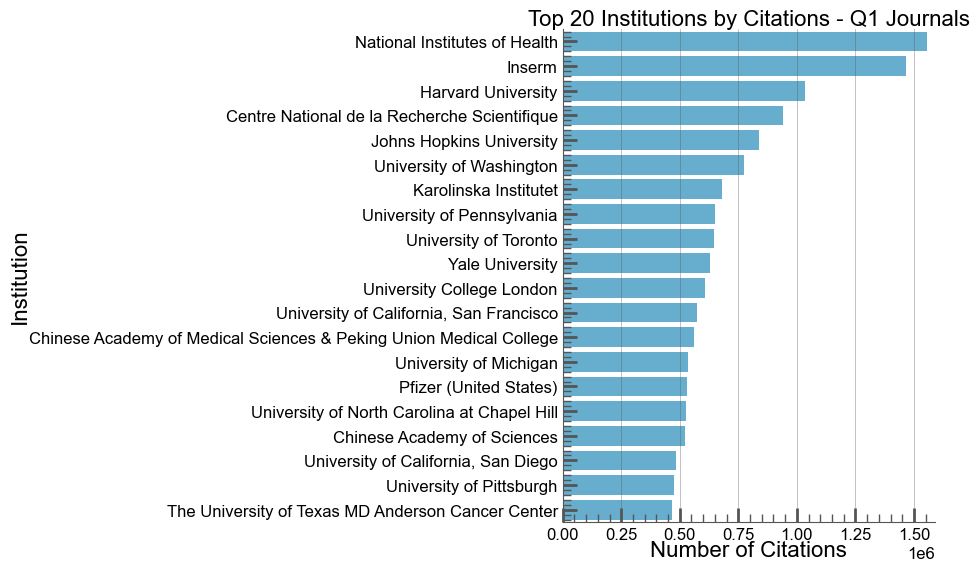

In [ ]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum.head(n=20), x = "cited_by_count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of Citations", fontsize=16)
    plt.title("Top 20 Institutions by Citations - Q1 Journals", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

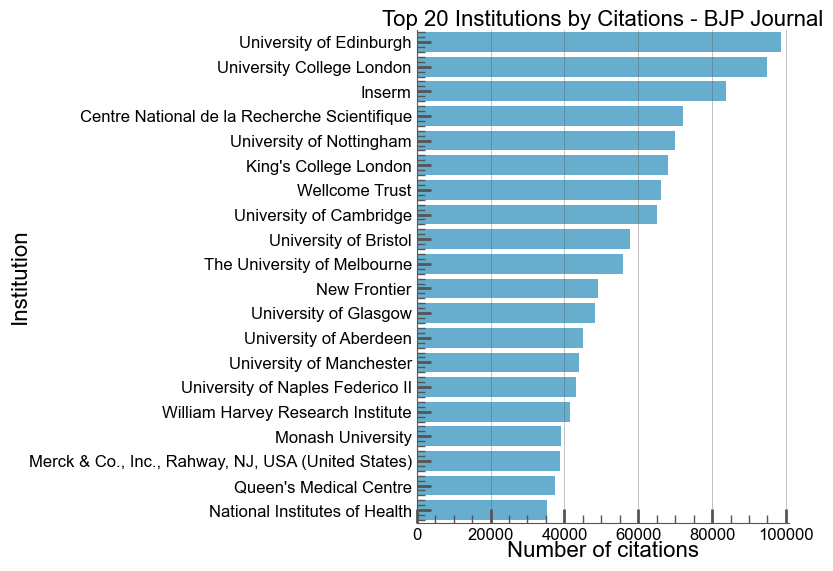

In [ ]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum_bjp.head(n=20), x = "cited_by_count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.title("Top 20 Institutions by Citations - BJP Journal", fontsize=16)
    plt.show()

In [ ]:
group_institutions_sum = (
    institutions
    .select(["institution_simple", "count", "cited_by_count", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("count", descending=True)

group_institutions_sum_bjp = (
    institutions_bjp
    .select(["institution_simple", "count", "cited_by_count", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("count", descending=True)

In [ ]:
group_institutions_sum = group_institutions_sum.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I183935753"))
      .then(pl.lit(king))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_sum = group_institutions_sum.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I4210137227"))
      .then(pl.lit(queen))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_sum_bjp = group_institutions_sum_bjp.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I183935753"))
      .then(pl.lit(king))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_sum_bjp = group_institutions_sum_bjp.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I4210137227"))
      .then(pl.lit(queen))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)


<Figure size 640x480 with 0 Axes>

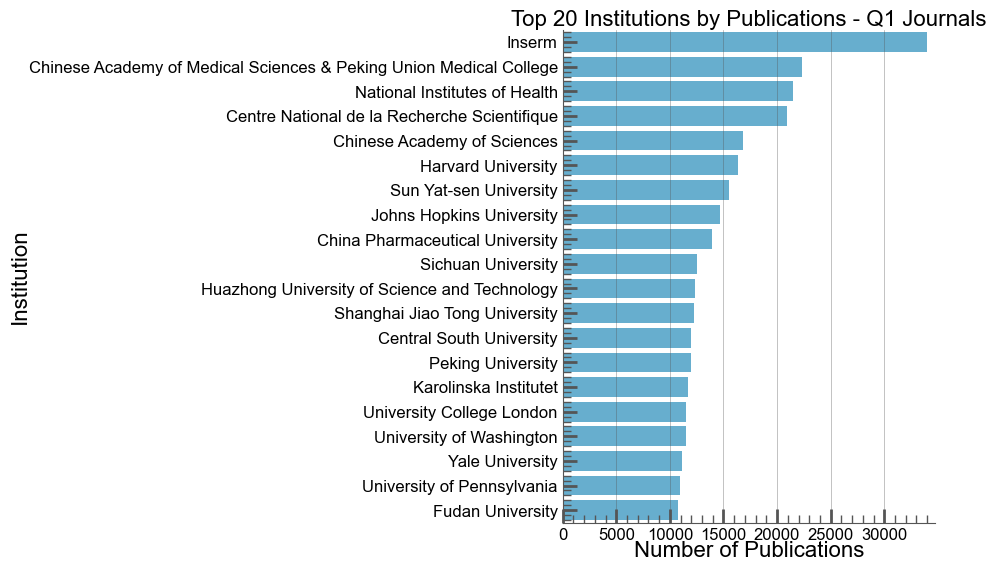

In [ ]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum.head(n=20), x = "count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of Publications", fontsize=16)
    plt.title("Top 20 Institutions by Publications - Q1 Journals", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

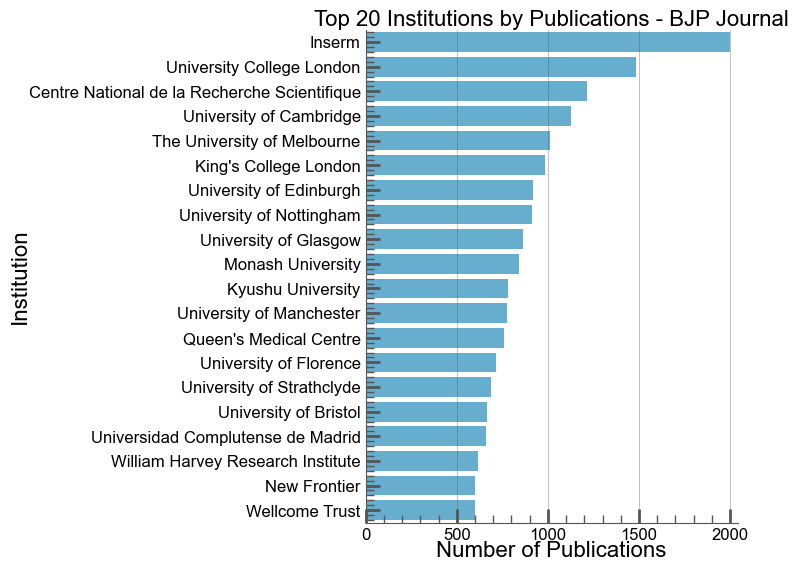

In [ ]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum_bjp.head(n=20), x = "count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of Publications", fontsize=16)
    plt.title("Top 20 Institutions by Publications - BJP Journal", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

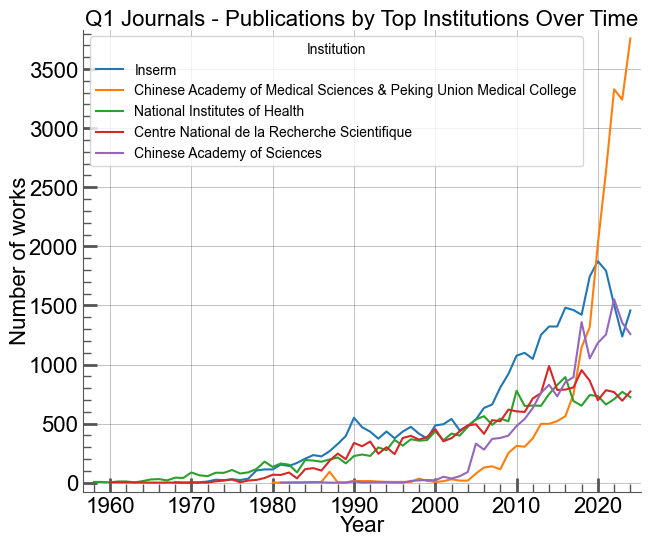

In [ ]:
group_filtered = group_institutionsyears.filter( pl.col("institution_simple").is_in(top_institutions) )

group_agg = group_filtered.group_by(["institution_simple", "year"]).agg(
    pl.sum("count").alias("count")
).sort(["institution_simple", "year"])

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
           "#bcbd22", "#17becf"]

unique_institutions = top_institutions
institution_colors = {inst: palette[i % len(palette)] for i, inst in enumerate(unique_institutions)}

plt.figure(figsize=(7.2, 6))

for inst in unique_institutions:
    df_inst = group_agg.filter(pl.col("institution_simple") == inst).sort("year")
    plt.plot(df_inst["year"].to_list(), df_inst["count"].to_list(),
             label=inst, color=institution_colors[inst])

plt.ylabel("Number of works", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Institution")
plt.title("Q1 Journals - Publications by Top Institutions Over Time", fontsize=16)
plt.show()


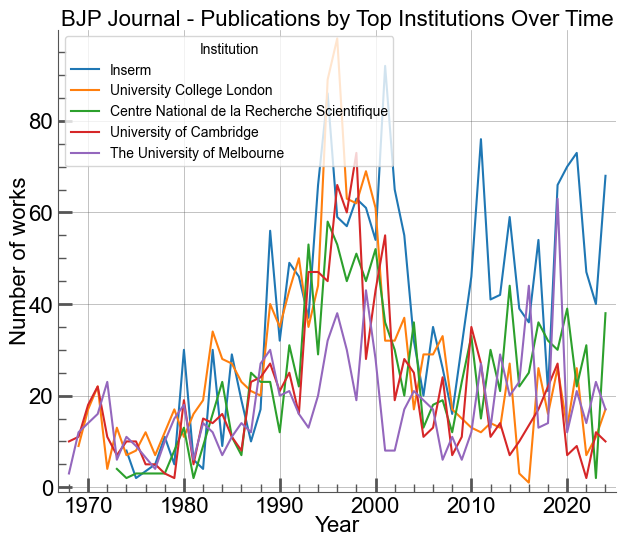

In [ ]:
group_filtered = group_institutionsyears_bjp.filter( pl.col("institution_simple").is_in(top_institutions_bjp) )

group_agg = group_filtered.group_by(["institution_simple", "year"]).agg(
    pl.sum("count").alias("count")
).sort(["institution_simple", "year"])

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
           "#bcbd22", "#17becf"]

unique_institutions = top_institutions_bjp
institution_colors = {inst: palette[i % len(palette)] for i, inst in enumerate(unique_institutions)}

plt.figure(figsize=(7.2, 6))

for inst in unique_institutions:
    df_inst = group_agg.filter(pl.col("institution_simple") == inst).sort("year")
    plt.plot(df_inst["year"].to_list(), df_inst["count"].to_list(),
             label=inst, color=institution_colors[inst])

plt.ylabel("Number of works", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Institution")
plt.title("BJP Journal - Publications by Top Institutions Over Time", fontsize=16)
plt.show()


In [ ]:
universities_names = [
    "Harvard University",
    "University College London",
    "University of Washington",
    "University of Michigan",
    "University of California, San Francisco",
    "University of Toronto",
    "Johns Hopkins University",
    "University of California, San Diego",
    "University of North Carolina at Chapel Hill",
    "University of Pennsylvania",
    "University of Cambridge",
    "The University of Melbourne",
    "King's College London",
    "Stanford University",
    "Karolinska Institutet",
    "Yale University",
    "University of Oxford",
    "University of California, Los Angeles",
    "University of Chicago",
    "University of Pennsylvania",
    "University of Bristol",
    "University of Edinburgh",
    "University of Manchester",
    "University of Sydney",
    "University of Nottingham",
    "Monash University",
    "Johns Hopkins University",
]

top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

top_10_universities_bjp = (
    group_institutions_sum_bjp
    .filter(pl.col("institution_simple").is_in(universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

In [ ]:
bigpharma_names = ["Johnson & Johnson",
                    "Roche", 
                    "Merck",
                    "Pfizer", 
                    "AbbVie",
                    "AstraZeneca",
                    "Novartis", 
                    "Bristol-Myers Squibb",
                    "Eli Lilly",
                    "Sanofi",
                    "Novo Nordisk",
                    "GlaxoSmithKline",
                    "Amgen",
                    "Takeda",
                    "Boehringer Ingelheim",
                    "Gilead Sciences",
                    "Bayer",
                    "Teva Pharmaceuticals",
                    "CSL",
                    "BMS",
                    "Wellcome Trust",
                    "New Frontier"
                    ] 

starts_with_expression = pl.col("institution_simple").str.starts_with(bigpharma_names[0])
for name in bigpharma_names[1:]:
    starts_with_expression =  starts_with_expression | pl.col("institution_simple").str.starts_with(name)

bigpharma = (
        institutions
        .filter(
            starts_with_expression
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").str.starts_with("Bristol-Myers Squibb")).then(pl.lit("Bristol-Myers Squibb"))
            .otherwise(pl.col("institution_simple").str.replace_all(r"[(–\-)]", ",").str.split(",").list.get(0).str.strip_chars()) #warning: \ before the - otherwise regex think it's a range of character like a-z=alphabet
            .alias("institution_simple"))
        
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").is_in(["Merck & Co.", "Merck Serono", "Merck Canada Inc.", "Merck Institute for Science Education"])).then(pl.lit("Merck"))
            .when(pl.col("institution_simple").is_in(["Pfizer-University of Granada-Junta de Andalucía Centre for Genomics and Oncological Research"])).then(pl.lit("Pfizer"))
            .when(pl.col("institution_simple").is_in(["Novartis Institutes for BioMedical Research", "Novartis Foundation"])).then(pl.lit("Novartis"))
            .when(pl.col("institution_simple").is_in(["Roche Pharma AG"])).then(pl.lit("Roche"))
            .when(pl.col("institution_simple").is_in(["Novo Nordisk Foundation"])).then(pl.lit("Novo Nordisk"))
            .otherwise(pl.col("institution_simple"))
            .alias("institution_simple"))
        
    )
)

bigpharma_bjp = (
        institutions_bjp
        .filter(
            starts_with_expression
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").str.starts_with("Bristol-Myers Squibb")).then(pl.lit("Bristol-Myers Squibb"))
            .otherwise(pl.col("institution_simple").str.replace_all(r"[(–\-)]", ",").str.split(",").list.get(0).str.strip_chars()) #warning: \ before the - otherwise regex think it's a range of character like a-z=alphabet
            .alias("institution_simple"))
        
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").is_in(["Merck & Co.", "Merck Serono", "Merck Canada Inc.", "Merck Institute for Science Education"])).then(pl.lit("Merck"))
            .when(pl.col("institution_simple").is_in(["Pfizer-University of Granada-Junta de Andalucía Centre for Genomics and Oncological Research"])).then(pl.lit("Pfizer"))
            .when(pl.col("institution_simple").is_in(["Novartis Institutes for BioMedical Research", "Novartis Foundation"])).then(pl.lit("Novartis"))
            .when(pl.col("institution_simple").is_in(["Roche Pharma AG"])).then(pl.lit("Roche"))
            .when(pl.col("institution_simple").is_in(["Novo Nordisk Foundation"])).then(pl.lit("Novo Nordisk"))
            .otherwise(pl.col("institution_simple"))
            .alias("institution_simple"))
        
    )
)

bigpharma

shape: (86_992, 12)
┌──────┬────────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ year ┆ index_work ┆ cited_by_c ┆ mncs     ┆ … ┆ cumulative ┆ cumulative ┆ cumulative ┆ mean_past │
│ ---  ┆ ---        ┆ ount       ┆ ---      ┆   ┆ _count     ┆ _citations ┆ _mncs      ┆ _mncs_ins │
│ i64  ┆ u32        ┆ ---        ┆ f64      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ titutions │
│      ┆            ┆ i64        ┆          ┆   ┆ i64        ┆ i64        ┆ f64        ┆ ---       │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆            ┆ f64       │
╞══════╪════════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 1959 ┆ 7227       ┆ 16         ┆ 0.463768 ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ 1959 ┆ 7250       ┆ 9          ┆ 0.26087  ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ 1960 ┆ 7666       ┆ 24         ┆ 0.857821 ┆ … ┆ 1          ┆ 16         ┆ 0.463768   ┆ 0.463768  │
│ 1960 ┆ 7666       ┆ 24         ┆ 0.857821 ┆ … ┆ 2          ┆ 40         ┆ 1.321589   ┆ 0.660794  │
│ 1960 ┆ 7666       ┆ 24         ┆ 0.857821 ┆ … ┆ 3          ┆ 64         ┆ 2.179409   ┆ 0.72647   │
│ …    ┆ …          ┆ …          ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …         │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8748       ┆ 529730     ┆ 13283.2272 ┆ 1.51843   │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8749       ┆ 529730     ┆ 13283.2272 ┆ 1.518257  │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8750       ┆ 529730     ┆ 13283.2272 ┆ 1.518083  │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8751       ┆ 529730     ┆ 13283.2272 ┆ 1.51791   │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8752       ┆ 529730     ┆ 13283.2272 ┆ 1.517736  │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
└──────┴────────────┴────────────┴──────────┴───┴────────────┴────────────┴────────────┴───────────┘

In [ ]:
errors = [
    "Rochester General Hospital",
    "Rochester Institute of Technology",
    "Bayero University Kano",
    "Bayerisches Landesamt für Gesundheit und Lebensmittelsicherheit"
]

group_bigpharma = (
    bigpharma
    .drop(["institution_name", "institution_pos"])
    .group_by(by = "institution_simple", maintain_order=True)
    .sum()
    .sort("cited_by_count", descending=True)
    .filter(~(pl.col("by").is_in(errors)))
)

group_bigpharma = group_bigpharma.with_columns(
    kind = pl.lit("Company"),
    institution_simple = pl.col("by")
).drop(["by", "index_work", "year"])

group_bigpharma_bjp = (
    bigpharma_bjp
    .drop(["institution_name", "institution_pos"])
    .group_by(by = "institution_simple", maintain_order=True)
    .sum()
    .sort("cited_by_count", descending=True)
    .filter(~(pl.col("by").is_in(errors)))
)

group_bigpharma_bjp = group_bigpharma_bjp.with_columns(
    kind = pl.lit("Company"),
    institution_simple = pl.col("by")
).drop(["by", "index_work", "year"])

group_bigpharma

shape: (30, 9)
┌────────────┬────────────┬───────┬────────────┬───┬────────────┬────────────┬───────────┬─────────┐
│ cited_by_c ┆ mncs       ┆ count ┆ institutio ┆ … ┆ cumulative ┆ cumulative ┆ mean_past ┆ kind    │
│ ount       ┆ ---        ┆ ---   ┆ n_simple   ┆   ┆ _citations ┆ _mncs      ┆ _mncs_ins ┆ ---     │
│ ---        ┆ f64        ┆ i64   ┆ ---        ┆   ┆ ---        ┆ ---        ┆ titutions ┆ str     │
│ i64        ┆            ┆       ┆ str        ┆   ┆ i64        ┆ f64        ┆ ---       ┆         │
│            ┆            ┆       ┆            ┆   ┆            ┆            ┆ f64       ┆         │
╞════════════╪════════════╪═══════╪════════════╪═══╪════════════╪════════════╪═══════════╪═════════╡
│ 673897     ┆ 16583.0536 ┆ 10901 ┆ Pfizer     ┆ … ┆ 2917388143 ┆ 6.3850e7   ┆ 17934.946 ┆ Company │
│            ┆ 73         ┆       ┆            ┆   ┆            ┆            ┆ 859       ┆         │
│ 549406     ┆ 13565.7853 ┆ 9391  ┆ Merck      ┆ … ┆ 1983509339 ┆ 4.6329e7   ┆ 16297.813 ┆ Company │
│            ┆ 47         ┆       ┆            ┆   ┆            ┆            ┆ 371       ┆         │
│ 545202     ┆ 11950.9729 ┆ 8361  ┆ GlaxoSmith ┆ … ┆ 891726066  ┆ 1.7308e7   ┆ 14010.253 ┆ Company │
│            ┆ 66         ┆       ┆ Kline      ┆   ┆            ┆            ┆ 984       ┆         │
│ 489594     ┆ 11706.4542 ┆ 7847  ┆ Novartis   ┆ … ┆ 780051884  ┆ 1.7161e7   ┆ 12236.333 ┆ Company │
│            ┆ 28         ┆       ┆            ┆   ┆            ┆            ┆ 438       ┆         │
│ 437643     ┆ 10156.3873 ┆ 7038  ┆ Eli Lilly  ┆ … ┆ 1236202849 ┆ 2.8077e7   ┆ 9967.9204 ┆ Company │
│            ┆ 48         ┆       ┆            ┆   ┆            ┆            ┆ 31        ┆         │
│ …          ┆ …          ┆ …     ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …       │
│ 82         ┆ 2.28901    ┆ 3     ┆ Wellcome   ┆ … ┆ 101        ┆ 2.630609   ┆ 2.764305  ┆ Company │
│            ┆            ┆       ┆ Trust      ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Liverpool  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Glasg…     ┆   ┆            ┆            ┆           ┆         │
│ 53         ┆ 1.108824   ┆ 1     ┆ Boehringer ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ Ingelheim  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Foundatio… ┆   ┆            ┆            ┆           ┆         │
│ 24         ┆ 0.432897   ┆ 1     ┆ Bayerische ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ s          ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Landesamt  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ für Umwe…  ┆   ┆            ┆            ┆           ┆         │
│ 14         ┆ 0.435707   ┆ 1     ┆ Wellcome   ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ Trust/DBT  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ India      ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Allia…     ┆   ┆            ┆            ┆           ┆         │
│ 8          ┆ 0.213059   ┆ 1     ┆ Rochester  ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ Center for ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Behaviora… ┆   ┆            ┆            ┆           ┆         │
└────────────┴────────────┴───────┴────────────┴───┴────────────┴────────────┴───────────┴─────────┘

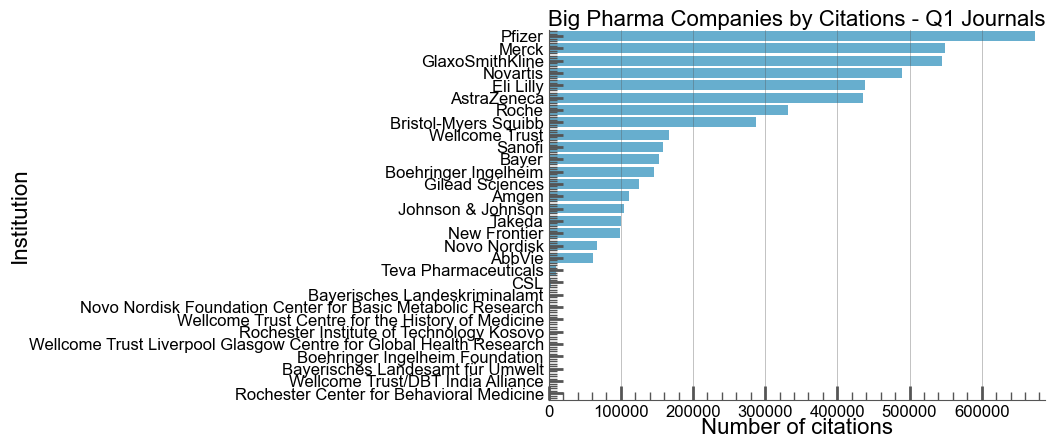

In [ ]:
with aq.load_theme("scientific"):
    sns.barplot(data = group_bigpharma, x = "cited_by_count", y = "institution_simple", orient = "h",  legend = True)
    #plt.xticks(rotation = 90)
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.title("Big Pharma Companies by Citations - Q1 Journals", fontsize=16)
    plt.show()

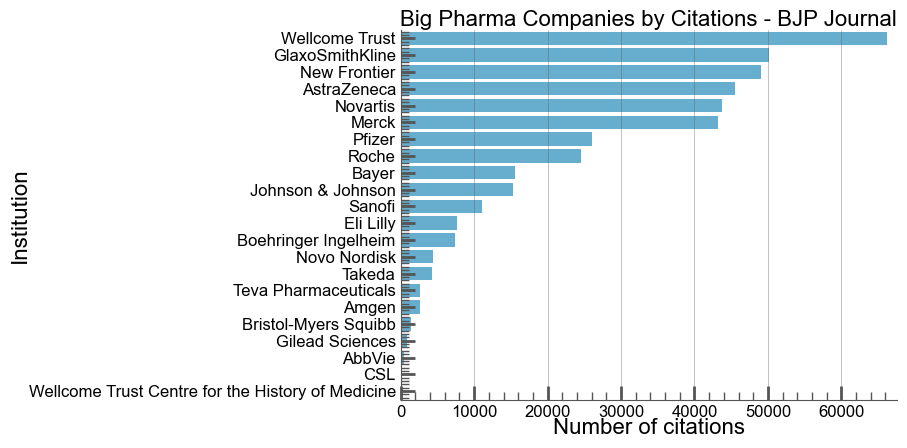

In [ ]:
with aq.load_theme("scientific"):
    sns.barplot(data = group_bigpharma_bjp, x = "cited_by_count", y = "institution_simple", orient = "h",  legend = True)
    #plt.xticks(rotation = 90)
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.title("Big Pharma Companies by Citations - BJP Journal", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

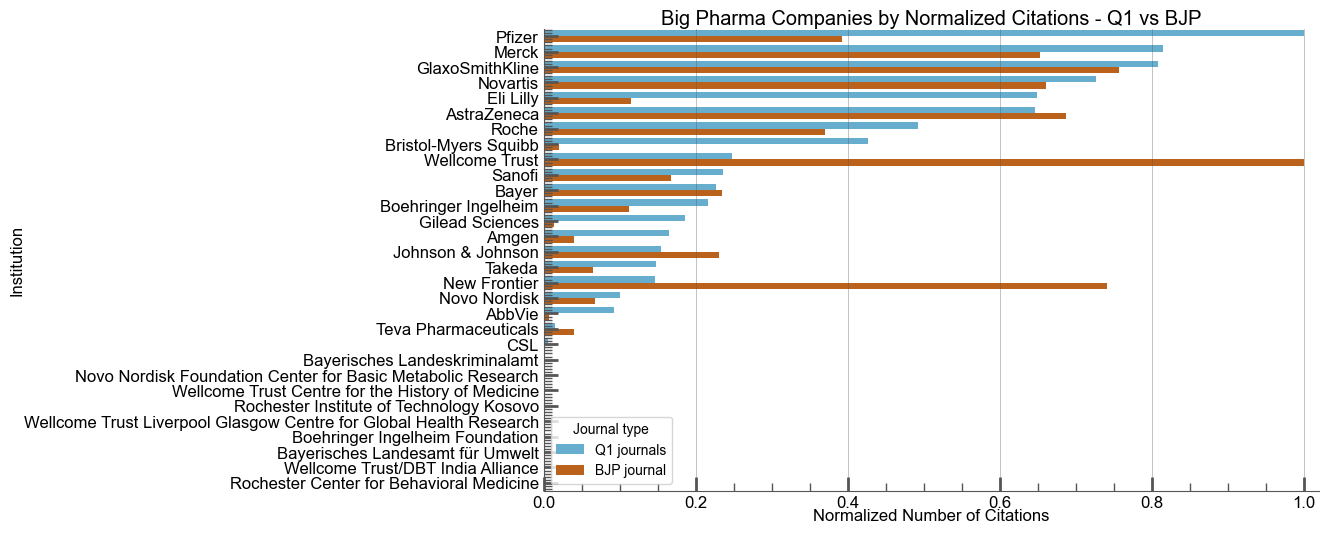

In [ ]:

group_bigpharma_norma = group_bigpharma.with_columns(
    (pl.col("cited_by_count") / pl.col("cited_by_count").max()).alias("normalized")
)

group_bigpharma_bjp_norma = group_bigpharma_bjp.with_columns(
    (pl.col("cited_by_count") / pl.col("cited_by_count").max()).alias("normalized")
)

df1 = group_bigpharma_norma.with_columns(pl.lit("Q1 journals").alias("source")).to_pandas()
df2 = group_bigpharma_bjp_norma.with_columns(pl.lit("BJP journal").alias("source")).to_pandas()

df_all = pd.concat([df1, df2], ignore_index=True)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_all,
        x="normalized",
        y="institution_simple",
        hue="source",
        orient="h"
    )
    plt.xlabel("Normalized Number of Citations")
    plt.ylabel("Institution")
    plt.legend(title="Journal type")
    plt.title("Big Pharma Companies by Normalized Citations - Q1 vs BJP")
    plt.show()

In [ ]:
group_national_institutions = (
    group_institutions_sum
    .head(4)  # 3 top national institutions but without Harvard
    .filter(pl.col("institution_simple") != "Harvard University")
    .filter(pl.col("institution_simple") != "Chinese Academy of Medical Sciences & Peking Union Medical College")
    .with_columns([pl.lit("National Institution").alias("kind")])
    .drop("institution_name")
)
impact_universities = top_10_universities["cited_by_count"].sum()/top_10_universities["count"].sum()
impact_bigpharma = group_bigpharma["cited_by_count"].sum()/group_bigpharma["count"].sum()
impact_national = group_national_institutions["cited_by_count"].sum()/ group_national_institutions["count"].sum()
print(impact_national)
print(impact_universities)
print(impact_bigpharma)

51.89484697881245
57.99835988528788
58.23390466543115


In [ ]:
group_national_institutions_bjp = (
    group_institutions_sum_bjp
    .head(7)  # 3 top national institutions but without Harvard
    .filter(pl.col("institution_simple") != "Harvard University")
    .filter(pl.col("institution_simple") != "University College London")
    .filter(pl.col("institution_simple") != "University of Edinburgh")
    .filter(pl.col("institution_simple") != "University of Cambridge")
    .filter(pl.col("institution_simple") != "The University of Melbourne")
    .filter(pl.col("institution_simple") != "King's College London")
    .with_columns([pl.lit("National Institution").alias("kind")])
    .drop("institution_name")
)
impact_universities_bjp = top_10_universities_bjp["cited_by_count"].sum()/top_10_universities_bjp["count"].sum()
impact_bigpharma_bjp = group_bigpharma_bjp["cited_by_count"].sum()/group_bigpharma_bjp["count"].sum()
impact_national_bjp = group_national_institutions_bjp["cited_by_count"].sum()/ group_national_institutions_bjp["count"].sum()
print(impact_national_bjp)
print(impact_universities_bjp)
print(impact_bigpharma_bjp)

48.50621504039776
66.0880367036011
75.7532281205165


In [ ]:
top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

group_bigpharma = group_bigpharma.select(top_10_universities.columns)

top_20 = pl.concat([
    top_10_universities.head(7),
    group_bigpharma.head(6),
    group_national_institutions
], how="vertical").sort("cited_by_count", descending=True)


In [ ]:
top_10_universities_bjp = (
    group_institutions_sum_bjp
    .filter(pl.col("institution_simple").is_in(universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

print(top_10_universities_bjp.head(7),
    group_bigpharma_bjp.head(6),
    group_national_institutions_bjp)

group_bigpharma_bjp = group_bigpharma_bjp.select(top_10_universities.columns)

top_20_bjp = pl.concat([
    top_10_universities_bjp.head(7),
    group_bigpharma_bjp.head(6),
    group_national_institutions_bjp
], how="vertical").sort("cited_by_count", descending=True)


shape: (7, 4)
┌─────────────────────────────┬───────┬────────────────┬────────────┐
│ institution_simple          ┆ count ┆ cited_by_count ┆ kind       │
│ ---                         ┆ ---   ┆ ---            ┆ ---        │
│ str                         ┆ i64   ┆ i64            ┆ str        │
╞═════════════════════════════╪═══════╪════════════════╪════════════╡
│ University College London   ┆ 1482  ┆ 94767          ┆ University │
│ University of Cambridge     ┆ 1128  ┆ 65204          ┆ University │
│ The University of Melbourne ┆ 1012  ┆ 55883          ┆ University │
│ King's College London       ┆ 987   ┆ 68201          ┆ University │
│ University of Edinburgh     ┆ 920   ┆ 98794          ┆ University │
│ University of Nottingham    ┆ 912   ┆ 69847          ┆ University │
│ Monash University           ┆ 840   ┆ 38984          ┆ University │
└─────────────────────────────┴───────┴────────────────┴────────────┘ shape: (6, 5)
┌────────────────────┬───────┬────────────────┬─────────────┬─

ShapeError: unable to append to a DataFrame of width 4 with a DataFrame of width 5

In [ ]:
kinds = sorted(set(top_20["kind"].unique()) | set(top_20_bjp["kind"].unique()))
base_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
                "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
                "#bcbd22", "#17becf"]

palette = {kind: color for kind, color in zip(kinds, base_palette)}

with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)
    plt.xlabel("Number of citations", fontsize = 16)
    plt.ylabel("Institution", fontsize=16)
    plt.title("Top Institutions by Citations - Q1 Journals", fontsize=16)
    plt.show()

In [ ]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = top_20_bjp, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)
    plt.xlabel("Number of citations", fontsize = 16)
    plt.ylabel("Institution", fontsize=16)
    plt.title("Top Institutions by Citations - BJP Journal", fontsize=16)
    plt.show()

In [ ]:

cols_to_stats = ["cited_by_count", "age", "count", "mncs"]

agg_exprs = []
for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))

def group_by_institution(df):
    return (
        df.with_columns(age=pl.lit(2025) - pl.col("year"))  
          .drop(["institution_pos", "year"])              
          .group_by("institution_simple", maintain_order=True)
          .agg(
              cited_by_count=pl.col("cited_by_count").sum(),
              count = pl.col("count").sum(),
              *agg_exprs
          )
          .sort("cited_by_count", descending=True)
    )

group_institutions = group_by_institution(institutions)
group_institutions_bjp = group_by_institution(institutions_bjp)

king = "King's College London"
queen = "Queen's Medical Centre"

group_institutions = group_institutions.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I183935753"))
      .then(pl.lit(king))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions = group_institutions.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I4210137227"))
      .then(pl.lit(queen))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_bjp = group_institutions_bjp.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I183935753"))
      .then(pl.lit(king))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)

group_institutions_bjp = group_institutions_bjp.with_columns(
    pl.when(pl.col("institution_simple").str.contains("I4210137227"))
      .then(pl.lit(queen))
      .otherwise(pl.col("institution_simple"))
      .alias("institution_simple")
)
group_institutions



In [ ]:
from adjustText import adjust_text
top_20_institutions = group_institutions_bjp.head(20)


top_20_institutions = top_20_institutions.with_columns([
    pl.col("count").log().alias("publications_log"),  # log des publications
])

top_20_institutions = top_20_institutions.with_columns(
    pl.col("mncs_mean").log().alias("mncs_log"),  # citations centrées
)


pub_log = top_20_institutions["publications_log"].to_numpy()
x_min = np.min(pub_log)
x_max = np.max(pub_log)

mncs_log = top_20_institutions["mncs_log"].to_numpy()
y_min = np.min(mncs_log)
y_max = np.max(mncs_log)



top_20_institutions = top_20_institutions.with_columns([
    ((pl.col("publications_log") - x_min) / (x_max - x_min) * 2 - 1).alias("x_viz"),
    ((pl.col("mncs_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
])

plt.figure(figsize=(10, 10))

plt.scatter(
    top_20_institutions["x_viz"],
    top_20_institutions["y_viz"],
    s=100,
    color='skyblue',
    edgecolor='k',
    zorder=2
)

texts = []
for name, x, y in zip(
    top_20_institutions["institution_simple"],
    top_20_institutions["x_viz"],
    top_20_institutions["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    
    texts.append(plt.text(x, y, name, fontsize=10, fontweight="bold", color=color))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=1))

plt.axvline(0, color="black", linewidth=1)
plt.axhline(0, color="black", linewidth=1)

plt.grid(True, linestyle='--', alpha=0.5)

plt.plot(
    [-1.1, 1.1],
    [1.1, -1.1],
    color="black",
    linestyle="--",
    linewidth=1,
    zorder=1
)


plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Total Publications (log, scaled)")
plt.ylabel("Mean MNCS (log, scaled)")

plt.title("Top 20 BJP Institutions : Publications vs Mean MNCS")

plt.tight_layout()
plt.show()

In [ ]:

top_20_institutions = group_institutions.head(20)


top_20_institutions = top_20_institutions.with_columns([
    pl.col("count").log().alias("publications_log"),  # log des publications
])

top_20_institutions = top_20_institutions.with_columns(
    pl.col("mncs_mean").log().alias("mncs_log"),  # citations centrées
)


pub_log = top_20_institutions["publications_log"].to_numpy()
x_min = np.min(pub_log)
x_max = np.max(pub_log)

mncs_log = top_20_institutions["mncs_log"].to_numpy()
y_min = np.min(mncs_log)
y_max = np.max(mncs_log)



top_20_institutions = top_20_institutions.with_columns([
    ((pl.col("publications_log") - x_min) / (x_max - x_min) * 2 - 1).alias("x_viz"),
    ((pl.col("mncs_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
])

plt.figure(figsize=(10, 10))

plt.scatter(
    top_20_institutions["x_viz"],
    top_20_institutions["y_viz"],
    s=100,
    color='skyblue',
    edgecolor='k',
    zorder=2
)

texts = []
for name, x, y in zip(
    top_20_institutions["institution_simple"],
    top_20_institutions["x_viz"],
    top_20_institutions["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    
    texts.append(plt.text(x, y, name, fontsize=10, fontweight="bold", color=color))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=1))

plt.axvline(0, color="black", linewidth=1)
plt.axhline(0, color="black", linewidth=1)

plt.grid(True, linestyle='--', alpha=0.5)

plt.plot(
    [-1.1, 1.1],
    [1.1, -1.1],
    color="black",
    linestyle="--",
    linewidth=1,
    zorder=1
)


plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Total Publications (log, scaled)")
plt.ylabel("Mean MNCS (log, scaled)")

plt.title("Top 20 Q1 Institutions : Publications vs Mean MNCS")

plt.tight_layout()
plt.show()

In [ ]:
def shorten_institution(name):
    if name is None:
        return None
    parts = name.split()
    if len(parts) <= 2:
        return name
    if parts[0] == "King's": 
        parts[-1] = 'London'
    return f"{parts[0]} […] {parts[-1]}"

institutions = institutions.with_columns(
    pl.col("institution_simple")
    .map_elements(shorten_institution)
    .alias("institution_short")
)

grouped = (
    institutions
    .group_by("index_work")
    .agg(
        pl.col("institution_short")
        .drop_nulls()
        .unique()
    )
)

pairs_counter = {}
inst_totals = {}

for row in grouped.iter_rows(named=True):
    insts = row["institution_short"]

    if len(insts) >= 2:
        for pair in itertools.combinations(sorted(insts), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            inst_totals[pair[0]] = inst_totals.get(pair[0], 0) + 1
            inst_totals[pair[1]] = inst_totals.get(pair[1], 0) + 1


top_institutions = sorted(inst_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_institutions = [i for i, _ in top_institutions]


top_institutions



In [ ]:
import requests
top_institutions_info = {}

short_to_simple = {
    row["institution_short"]: row["institution_simple"]
    for row in institutions.select(["institution_short", "institution_simple"]).unique().to_dicts()
}

def search_institution(name):
    url = "https://api.openalex.org/institutions"
    params = {
        "search": name,
        "per-page": 1
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    results = r.json()["results"]
    return results[0] if results else None


for short_name in top_institutions:
    parts = short_name.split()
    full_name = short_to_simple[short_name]
    if parts[0] == "King's": 
        full_name = "King's College - Pennsylvania"
    if parts[0] == "University" and parts[-1] == "Center": 
        full_name = "University of Arizona Cancer Center"
    print(parts[0], short_name,full_name)
    inst = search_institution(full_name)
    if inst:
        top_institutions_info[short_name] = {
            "id": inst["id"],
            "country": inst.get("country_code"),
            "display_name": inst.get("display_name"),
        }
    else:
        top_institutions_info[short_name] = {
            "id": None,
            "country": None,
            "display_name": full_name,
        }

In [ ]:
G = nx.Graph()

for (i1, i2), count in pairs_counter.items():
    if i1 in top_institutions_info and i2 in top_institutions_info and i1 != i2:
        G.add_edge(i1, i2, weight=count)

node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)

edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)

countries = [top_institutions_info[node].get("country") for node in G.nodes()]
unique_countries = [c for c in set(countries) if c is not None]

if any(c is None for c in countries):
    unique_countries.append("Unknown")

cmap = cm.get_cmap("tab20")
color_cycle = cmap.colors if hasattr(cmap, "colors") else [cmap(i) for i in range(len(unique_countries))]
country_to_color = {c: color_cycle[i % len(color_cycle)] for i, c in enumerate(unique_countries)}

node_colors = [
    country_to_color.get(top_institutions_info[node].get("country"), country_to_color.get("Unknown"))
    for node in G.nodes()
]

pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, edge_color='lightgray', alpha=0.5)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=node_colors,
                       alpha=0.9, edgecolors='black', linewidths=0.5)
nx.draw_networkx_labels(G, pos, labels={n: top_institutions_info[n]["display_name"] for n in G.nodes()},
                        ax=ax, font_size=9, font_weight='bold')

for country, color in country_to_color.items():
    ax.scatter([], [], c=[color], label=country, s=200)
ax.legend(title="Country", loc="upper right", fontsize=9)

ax.set_title("Top 25 Institutions Collaboration Network - Q1 Journals ", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
institutions_bjp = institutions_bjp.with_columns(
    pl.col("institution_simple")
    .map_elements(shorten_institution)
    .alias("institution_short")
)

grouped_bjp = (
    institutions_bjp
    .group_by("index_work")
    .agg(
        pl.col("institution_short")
        .drop_nulls()
        .unique()
    )
)


pairs_counter = {}
inst_totals = {}

for row in grouped_bjp.iter_rows(named=True):
    insts = row["institution_short"]

    if len(insts) >= 2:
        for pair in itertools.combinations(sorted(insts), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            inst_totals[pair[0]] = inst_totals.get(pair[0], 0) + 1
            inst_totals[pair[1]] = inst_totals.get(pair[1], 0) + 1


top_institutions_bjp = sorted(inst_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_institutions_bjp = [i for i, _ in top_institutions_bjp]



In [ ]:
top_institutions_info = {}

short_to_simple = {
    row["institution_short"]: row["institution_simple"]
    for row in institutions_bjp.select(["institution_short", "institution_simple"]).unique().to_dicts()
}

for short_name in top_institutions_bjp:
    parts = short_name.split()
    full_name = short_to_simple[short_name]
    if parts[0] == "King's": 
        full_name = "King's College London"
    if parts[-1] == "Melbourne": 
        full_name = "University of Melbourne"
    inst = search_institution(full_name)

    if inst:
        top_institutions_info[short_name] = {
            "id": inst["id"],
            "country": inst.get("country_code"),
            "display_name": inst.get("display_name"),
        }
    else:
        top_institutions_info[short_name] = {
            "id": None,
            "country": None,
            "display_name": full_name,
        }
        

In [ ]:

G = nx.Graph()

for (i1, i2), count in pairs_counter.items():
    if i1 in top_institutions_info and i2 in top_institutions_info and i1 != i2:
        G.add_edge(i1, i2, weight=count)

node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)

edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)

countries = [top_institutions_info[node].get("country") for node in G.nodes()]
unique_countries = [c for c in set(countries) if c is not None]

if any(c is None for c in countries):
    unique_countries.append("Unknown")

cmap = cm.get_cmap("tab20")
color_cycle = cmap.colors if hasattr(cmap, "colors") else [cmap(i) for i in range(len(unique_countries))]
country_to_color = {c: color_cycle[i % len(color_cycle)] for i, c in enumerate(unique_countries)}

node_colors = [
    country_to_color.get(top_institutions_info[node].get("country"), country_to_color.get("Unknown"))
    for node in G.nodes()
]

pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, edge_color='lightgray', alpha=0.5)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=node_colors,
                       alpha=0.9, edgecolors='black', linewidths=0.5)
nx.draw_networkx_labels(G, pos, labels={n: top_institutions_info[n]["display_name"] for n in G.nodes()},
                        ax=ax, font_size=9, font_weight='bold')

for country, color in country_to_color.items():
    ax.scatter([], [], c=[color], label=country, s=200)
ax.legend(title="Country", loc="upper right", fontsize=9)

ax.set_title("Top 25 Institutions Collaboration Network - BJP Journal ", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
pairs_counter = {}
inst_totals = {}

for row in grouped_bjp.iter_rows(named=True):
    insts = row["institution_short"]

    if len(insts) >= 2:
        for pair in itertools.combinations(sorted(insts), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            inst_totals[pair[0]] = inst_totals.get(pair[0], 0) + 1
            inst_totals[pair[1]] = inst_totals.get(pair[1], 0) + 1


top_institutions_bjp = sorted(inst_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_institutions_bjp = [i for i, _ in top_institutions_bjp]

top_institutions_info = {}

short_to_simple = {
    row["institution_short"]: row["institution_simple"]
    for row in institutions_bjp.select(["institution_short", "institution_simple"]).unique().to_dicts()
}

for short_name in top_institutions_bjp:
    parts = short_name.split()
    full_name = short_to_simple[short_name]
    if parts[0] == "King's": 
        full_name = "King's College London"
    if parts[-1] == "Melbourne": 
        full_name = "University of Melbourne"
    inst = search_institution(full_name)

    if inst:
        top_institutions_info[short_name] = {
            "id": inst["id"],
            "country": inst.get("country_code"),
            "display_name": inst.get("display_name"),
        }
    else:
        top_institutions_info[short_name] = {
            "id": None,
            "country": None,
            "display_name": full_name,
        }
        


In [ ]:



institutions_col_q1 = [f"institution_{i}" for i in range(1, 193)]  # 192 for Q1
institutions_col_bjp = [f"institution_{i}" for i in range(1, 127)]  # 126 for BJP

def institutions_distinct_yearly(df, institutions_col):
    years = sorted(df["year"].unique().to_list())
    institutions_count = []

    for y in years:
        df_year = df.filter(pl.col("year") == y)
        inst_set = set()
        for col in institutions_col:
            inst_set.update(df_year[col].drop_nulls().to_list())
        institutions_count.append(len(inst_set))

    return years, institutions_count

years_q1, inst_q1 = institutions_distinct_yearly(works, institutions_col_q1)
years_bjp, inst_bjp = institutions_distinct_yearly(works_bjp, institutions_col_bjp)

print(inst_q1,inst_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, inst_q1, color="#3944f3", label="Q1 institutions", linewidth=2)
    plt.plot(years_bjp, inst_bjp, color="#f39c12", label="BJP institutions", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Number of Distinct Institutions", fontsize=14)
    plt.title("Institutional Diversity of Institutions Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(1950,2024)
    plt.show()

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["pct_multi_institutional"], color="#3944f3", label="Q1 % multi-institutional", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["pct_multi_institutional"], color="#f39c12", label="BJP % multi-institutional", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("% of Multi institutional Articles", fontsize=14)
plt.title("Percentage of Multi-institutional Articles Over Time - Q1 vs BJP ", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1950,2024)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["mean_citations_multi_institution"], color="#3944f3", label="Q1 multi-institution", linewidth=2)
plt.plot(q1_collab["year"], q1_collab["mean_citations_single_institution"], color="#39daf3", label="Q1 single-institution", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("Average Citations", fontsize=14)
plt.ylim(0, 100)
plt.title("Average Q1 Citations by Institutional Collaboration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1950,2024)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(bjp_collab["year"], bjp_collab["mean_citations_single_institution"], color="#f31212", label="BJP single-institution", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["mean_citations_multi_institution"], color="#f39c12", label="BJP multi-institution", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("Average Citations", fontsize=14)
plt.ylim(0, 100)
plt.title("Average BJP Citations by Institutional Collaboration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1950,2024)
plt.show()

In [ ]:
institutions_q1_ci = group_Ninstitutions["institutions_distinct_count"].to_numpy()
mean_q1 = group_Ninstitutions["mncs_mean"].to_numpy()
median_q1 = group_Ninstitutions["mncs_median"].to_numpy()
low_q1 = group_Ninstitutions["mncs_p2_5"].to_numpy()
high_q1 = group_Ninstitutions["mncs_p97_5"].to_numpy()

institutions_bjp_ci = group_Ninstitutions_bjp["institutions_distinct_count"].to_numpy()
mean_bjp = group_Ninstitutions_bjp["mncs_mean"].to_numpy()
median_bjp = group_Ninstitutions_bjp["mncs_median"].to_numpy()
low_bjp = group_Ninstitutions_bjp["mncs_p2_5"].to_numpy()
high_bjp = group_Ninstitutions_bjp["mncs_p97_5"].to_numpy()


with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(institutions_q1_ci, mean_q1, color="#3944f3", label="Q1 works mean")
    #plt.plot(institutions_q1_ci, median_q1, color="#39daf3",label="Q1 works median")
    #plt.fill_between(institutions_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(institutions_bjp_ci, mean_bjp, color="#f39c12", label="BJP works mean")
    #plt.plot(institutions_bjp_ci, median_bjp, color="#f31212",label="BJP works median")
    #plt.fill_between(institutions_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)
    
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of institutions", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xlim(0.9, 20.1)
    plt.ylim(0, 3)
    plt.legend(fontsize=14)
    plt.title("MNCS by Number of Institutions - Q1 vs BJP", fontsize=16)
    plt.show()

In [ ]:
r_pearson, p_pearson = st.pearsonr(works["institutions_distinct_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["institutions_distinct_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")